# <font size="10"><center>Comment on peut utiliser Snorkel chez Qwarry</center></font>

**<font size="5"><span style="color:red">Attention!</span></font>** <font size="4">changement de la classification hiérarchique prévu (dans le future proche!) de la donnée chez Qwarry</font>

**<font size="5"><center> multiclass/flat classification $\implies$ binaire/local classifier per node (LCN) </center></font>**


In this POC, we use Snorkel to output a hierarchical multi-task classification on the following nodes:

T0: Y0 ∈ {8 (Sports), 2 (Automobile)}  

T1: Y1 ∈ {8-01 (Sports_American Football), 8-02 (Sports_Auto Racing), 8-03 (Sports_Badminton), 8-04 (Sports_Baseball), 8-05 (Sports_Basketball), 8-06 (Sports_Volleyball)}  

T2: Y2 ∈ {2-05 (Automobile_Auto Body Styles_Convertible), 2-06 (Automobile_Auto Body Styles_Coupe), 2-10 (Automobile_Auto Body Styles_Minivan / Monospace), 2-23 (Automobile_Auto Body Styles_Pickup Trucks), 2-24 (Automobile_Auto Luxe), 2-27 (Automobile_Auto Green)}  


Strategy: The parent node is T0 and the child nodes are T1 and T2. We first output (a one vs all) Snorkel on the parent node which will then tell us whether to follow the nodes T1 and/or T2. Once we arrive at node/s T1/T2, we output (a one vs all) Snorkel at the corresponding child node. It should be possible to reduce this 2-step process (running Snorkel on parent node THEN on child node) with just 1-step using the Snorkel-Metal framework (in particular by following the ``Multi-task supervision tutorial"). 

In [1]:
import os

# Make sure we're running from the spam/ directory
if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("getting_started")

In [2]:
import pandas as pd

import numpy as np

#load (labelled) data, labelled from the period March-August 2020 in Qwarry. A total of 58,727 labelled URLs.
#This file can be found at https://drive.google.com/drive/u/1/folders/19AkNtIWvecRqSGtwu3Tf4aE5e9FN4ax9 and it is
#the file called ``catalogue_with_content_5-03-2021.csv"

df_train = pd.read_csv("/home/ildar/qwarry/catalogue_with_content_5-03-2021.csv")

df_train = df_train.drop("content_summ", axis=1)


#This file is grouped by category. For ease of choosing categories we de-group the data.

s = df_train['category'].str.split(',').apply(pd.Series, 1).stack()

s.index = s.index.droplevel(-1)

s.name = 'Category'

del df_train['category']

df_train_mod = df_train.join(s)

df_train_mod.reset_index(inplace = True, drop = True)


#print first five rows

df_train_mod.head()

,URL,content,Category
0,http://bcd.bzh/becedia/fr/breiz-atao,Breiz Atao Premières expériences\n\nFondé à l’...,31-07
1,http://blog.cnam.fr/sante/salle-de-consommatio...,Salle de consommation de drogues : une expérim...,31-06
2,http://blogdunarguile.fr/absolem-tokyo-rush,Présentation tabac : Absolem - Tokyo Rush FUME...,31-11
3,http://blogdunarguile.fr/adalya-introduction,Adalya : Introduction FUMER TUE\n\nLa loi Évin...,31-11
4,http://blogdunarguile.fr/adalya-lych-blue,Présentation tabac : Adalya - Lych Blue FUMER ...,31-11


In [3]:
#print last five rows

df_train_mod.tail()

,URL,content,Category
61203,https://blog.ariase.com/mobile/dossiers/reseau...,Le réseau mobile Bouygues Telecom Serez-vous b...,4-43
61204,https://blog.ariase.com/mobile/dossiers/servic...,Contacter Bouygues Telecom : numéros et adress...,4-43
61205,https://blog.ariase.com/mobile/dossiers/commen...,Comment résilier son forfait Bouygues Telecom ...,4-43
61206,https://blog.ariase.com/mobile/dossiers/5g-bou...,"5G : ""Le client ne va pas sentir une différenc...",4-43
61207,https://blog.ariase.com/mobile/dossiers/5g-bou...,Tout savoir sur la 5G de Bouygues Telecom Ce q...,4-43


In [4]:
#print category 2-05 (Automobile_Auto Body Styles_Convertible)

df_train_mod.loc[df_train_mod["Category"] == "2-05"]

,URL,content,Category
4016,http://www.autonews.fr/actualite/-volkswagen-t...,"Volkswagen T-Roc Cabriolet : tous les prix, to...",2-05
4018,http://www.autonews.fr/actualite/corvette-cabr...,Corvette cabriolet 2020 : le nouveau modèle à ...,2-05
4020,http://www.autonews.fr/actualite/decouvrables-...,Découvrables : le dernier été de l’A3 cabriole...,2-05
4022,http://www.autonews.fr/actualite/jaguar-f-type...,Jaguar F-Type : la sportive anglaise restylée ...,2-05
4026,http://www.autonews.fr/actualite/lexus-lc-500-...,Lexus LC 500 Cabriolet : la luxueuse nippone e...,2-05
...,...,...,...
58838,https://www.turbo.fr/volkswagen/eos/essai-auto...,Volkswagen EOS restylée 2.0 TDI 140 ch La Volk...,2-05
58840,https://www.turbo.fr/volkswagen/new-beetle/ess...,Volkswagen New Beetle Cabriolet 1.6 102 ch Alo...,2-05
58842,https://www.turbo.fr/volkswagen/nouvelle-cocci...,Essai : Volkswagen Coccinelle Dune Cabriolet (...,2-05
58843,https://www.turbo.fr/volkswagen/nouvelle-cocci...,Volkswagen Coccinelle Cabriolet — premier essa...,2-05


In [5]:
#print category 2-06 (Automobile_Auto Body Styles_Coupe)

df_train_mod.loc[df_train_mod["Category"] == "2-06"]

,URL,content,Category
2052,http://challengesautomobile.unblog.fr/2019/07/...,LeapMotor propose son premier modèle : un coup...,2-06
4468,http://www.carideal.com/blog/2009/01/04/alfa-r...,Alfa Romeo GT Coupe occasion Alfa Romeo GT occ...,2-06
4470,http://www.carideal.com/blog/2012/03/10/bmw-se...,BMW Série 6 Gran Coupé Futur BMW Série 6 Gran ...,2-06
4472,http://www.carideal.com/blog/2014/05/13/le-bmw...,Le BMW Série 2 Coupé La nouvelle BMW Série 2 C...,2-06
4474,http://www.carideal.com/blog/2015/11/03/essai-...,Essai Jaguar F TYPE Coupé V6 S Essai Jaguar F ...,2-06
...,...,...,...
60282,https://www.web-automobile.com/mercedes-benz-s...,"Mercedes Benz S 65 AMG coupé, Le confort ultim...",2-06
60284,https://www.web-automobile.com/mercedes-classe...,La Mercedes Classe S coupé concept très proche...,2-06
60286,https://www.web-automobile.com/nouveaute-rolls...,Nouveauté Rolls-Royce : La Phantom Drophead Co...,2-06
60288,https://www.web-automobile.com/nouvelle-merced...,Nouvelle Mercedes Benz GLE Coupé : Les premièr...,2-06


In [6]:
#print category 2-10 (Automobile_Auto Body Styles_Minivan / Monospace)

df_train_mod.loc[df_train_mod["Category"] == "2-10"]

,URL,content,Category
1813,http://blog.latrivenetacavi.com/fr/chrysler-po...,Chrysler Portal: la voiture électrique de dema...,2-10
1904,http://blog.vpn-autos.fr/toyota-prius-les-rais...,La Toyota Prius : un voiture hybride pionnière...,2-10
1948,http://blogmoteurs.blogs.lavoixdunord.fr/archi...,L'essai de la Toyota Prius + : au bonheur des ...,2-10
1960,http://blogpeda.ac-poitiers.fr/lp2i-si/2016/01...,La Toyota Prius II Étude 2 : Les Transports pr...,2-10
3057,http://news.hybridlife.org/2017-lautomobile-fu...,CES 2017: l’automobile du futur au service de ...,2-10
...,...,...,...
59266,https://www.usinenouvelle.com/article/une-tech...,Une technologie efficiente par nature Inauguré...,2-10
59961,https://www.voiture-electrique-populaire.fr/ac...,Volkswagen Bulli électrique : version 2011 du ...,2-10
59965,https://www.voiture7places.net/astuces-finance...,Astuces : financement de sa voiture familiale ...,2-10
60290,https://www.web-automobile.com/quel-monospace-...,Quel Monospace de 5 à 7 places choisir ? notre...,2-10


In [7]:
#print category 2-23 (Automobile_Auto Body Styles_Pickup Trucks)

df_train_mod.loc[df_train_mod["Category"] == "2-23"]

,URL,content,Category
3611,http://vusmag.com/hennessey-presente-le-jeep-g...,Hennessey présente le Jeep Gladiator Maximus a...,2-23
3647,http://www.4rouesmotrices.com/essais/Mercedes%...,Mercedes Benz X250d 4Matic Auto Librairie Merc...,2-23
3649,http://www.4rouesmotrices.com/essais/Mercedes%...,Mercedes Benz X350d Accueil 4rouesmotrices > E...,2-23
4009,http://www.auto-mag.info/essais/essai-mercedes...,ESSAI MERCEDES CLASSE X 350d V6 4MATIC DOUBLE ...,2-23
4070,http://www.autonews.fr/essai/mercedes-classe-x...,Essai Mercedes Classe X350d : force et nobless...,2-23
...,...,...,...
58690,https://www.turbo.fr/actualite-automobile/une-...,"Une Porsche Taycan pick-up, une fausse bonne i...",2-23
58806,https://www.turbo.fr/mercedes/classe-x/fiche-v...,Mercedes Classe X : Un baroudeur chic ! S'il e...,2-23
59300,https://www.utilitairemagazine.com/pick-up/ess...,"Essai Mercedes Classe X 4MATIC 350 D, un pick ...",2-23
60198,https://www.vroom.be/fr/actus/bollinger-lance-...,Bollinger lance un pick-up électrique Sur la b...,2-23


In [8]:
#print category 2-24 (Automobile_Auto Luxe)

df_train_mod.loc[df_train_mod["Category"] == "2-24"]

,URL,content,Category
1846,http://blog.maurelauto.fr/salon-francfort-teas...,Teaser de l'Audi e-tron Quattro Salon Auto de ...,2-24
1888,http://blog.quartierdesjantes.com/insolite-con...,Insolite : Le concept-car tout terrain de Lamb...,2-24
1901,http://blog.vpn-autos.fr/ranger-rover-evoque-e...,Ranger Rover Evoque élu voiture féminine de l’...,2-24
1954,http://blogmoteurs.blogs.lavoixdunord.fr/archi...,L'essai du Porsche Macan : un sacré petit diab...,2-24
2016,http://caraibes-eco-vehicule.over-blog.com/art...,Voiture sans Permis Electrique: Estrima Biro U...,2-24
...,...,...,...
60287,https://www.web-automobile.com/nouvelle-merced...,Nouvelle Mercedes Benz GLE Coupé : Les premièr...,2-24
60289,https://www.web-automobile.com/quel-monospace-...,Quel Monospace de 5 à 7 places choisir ? notre...,2-24
60291,https://www.web-automobile.com/spyshot-mercede...,Spyshot : Mercedes GLK Le restylage du crossov...,2-24
60293,https://www.web-automobile.com/troisieme-gener...,Troisième génération Audi TT coupé Jamais deux...,2-24


In [9]:
#print category 2-27 (Automobile_Auto Green)

df_train_mod.loc[df_train_mod["Category"] == "2-27"]

,URL,content,Category
1719,http://blog-auto.autojm.fr/article-toutes-les-...,Toutes les infos sur le nouveau Peugeot 2008 A...,2-27
1812,http://blog.latrivenetacavi.com/fr/chrysler-po...,Chrysler Portal: la voiture électrique de dema...,2-27
1847,http://blog.maurelauto.fr/salon-francfort-teas...,Teaser de l'Audi e-tron Quattro Salon Auto de ...,2-27
1886,http://blog.psychotestspermis.fr/voiture-sans-...,Voiture sans permis : la solution après la sus...,2-27
1903,http://blog.vpn-autos.fr/toyota-prius-les-rais...,La Toyota Prius : un voiture hybride pionnière...,2-27
...,...,...,...
60227,https://www.vspieces.com/blog/acheter-voiture-...,Conseils d'achat pour une voiture sans permis ...,2-27
60822,https://www.ziptuning.fr/blog/citroen-ami-elec...,"Citroën Ami : Prix, Autonomie, Caractéristique...",2-27
60824,https://www.ziptuning.fr/blog/le-mercedes-eqv-...,Le Mercedes EQV se montre pendant des tests en...,2-27
60827,https://www.ziptuning.fr/blog/renault-morphoz-...,"Renault Morphoz, le SUV 100% électrique qui s’...",2-27


In [82]:
#let's make a function which returns a Dataframe containing only certain categories.

def subcategory_dataframe(set_of_cats): 
    df_train = df_train_mod.copy()
    df_train = df_train.loc[df_train['Category'].isin(set_of_cats)]    
    return df_train


In [231]:
#Use the above function to output a table for sports (categories 8-01, 8-02, 8-03, 8-04, 8-05, 8-06) and a 
#table for
#automobile (categories 2-05, 2-06, 2-10, 2-23, 2-24, 2-27)

df_train_sports = subcategory_dataframe({"8-01", "8-02", "8-03", "8-04", "8-05", "8-06"})

df_train_voiture = subcategory_dataframe({"2-05", "2-06", "2-10", "2-23", "2-24", "2-27"})

df_train_sports_voiture = subcategory_dataframe({"8-01", "8-02", "8-03", "8-04", "8-05", "8-06", "2-05", "2-06", "2-10", "2-23", "2-24", "2-27"})

In [85]:
#lets's make a function which splits the data into train/validation/test sets in 80/10/10 ratio
#and regroups them by category

from sklearn.model_selection import train_test_split

def split_train_val_test(dataframe):
    X = dataframe
    y = dataframe["Category"]
    X_train, X_valid1, y_train, y_valid1 = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0, stratify=y)
    X_valid, X_test, y_valid, y_test = train_test_split(X_valid1, y_valid1, train_size=0.5, test_size=0.5,
                                                      random_state=0, stratify=y_valid1)
    X_train = X_train.groupby(['URL', "content"])['Category'].apply(list).reset_index()
    X_valid = X_valid.groupby(['URL', "content"])['Category'].apply(list).reset_index()
    X_test = X_test.groupby(['URL', "content"])['Category'].apply(list).reset_index()
    
    return X_train, X_valid, X_test


In [232]:
#Use the above function to output train/validation/test sets for sports and automobile

df_sports_train, df_sports_valid, df_sports_test = split_train_val_test(df_train_sports)

df_voiture_train, df_voiture_valid, df_voiture_test = split_train_val_test(df_train_voiture)

df_sports_voiture_train, df_sports_voiture_valid, df_sports_voiture_test = split_train_val_test(df_train_sports_voiture)

In [235]:
df_sports_voiture_test

,URL,content,Category
0,http://bcci26.fr/badminton/historique-badminton/,Historique du Badminton Historique du Badminto...,[8-03]
1,http://beachvolleyball.free.fr/regles_officiel...,REGLES OFFICIELLES du BEACH VOLLEY Moteur de r...,[8-06]
2,http://blog.maurelauto.fr/salon-francfort-teas...,Teaser de l'Audi e-tron Quattro Salon Auto de ...,[2-24]
3,http://deplacement-durable.over-blog.com/artic...,Une voiture électrique sans permis : le TamTam...,[2-27]
4,http://eromi.xyz/voiture-electrique/quel-contr...,Quel contrôle technique passer pour un véhicul...,[2-27]
...,...,...,...
270,https://www.vanlifemag.fr/presentationessais/v...,Volkswagen e-Bulli: un combi split-screen à l’...,[2-27]
271,https://www.viinz.com/automobile/test-audi-s5-...,La nouvelle Audi S5 Coupé à l'essai : couteau ...,[2-06]
272,https://www.viinz.com/automobile/test-infiniti...,Gran Turismo et V6 : le coupé Infiniti Q60S à ...,[2-06]
273,https://www.viinz.com/automobile/test-peugeot-...,La nouvelle Peugeot 508 GT PureTech 225 EAT8 à...,[2-24]


In [89]:
#Let's take a look at our training dataset df_voiture_train
#df_voiture_train.loc[[38]].to_string()

df_voiture_train

,URL,content,Category
0,http://blog-auto.autojm.fr/article-toutes-les-...,Toutes les infos sur le nouveau Peugeot 2008 A...,[2-27]
1,http://blog.latrivenetacavi.com/fr/chrysler-po...,Chrysler Portal: la voiture électrique de dema...,"[2-27, 2-10]"
2,http://blog.maurelauto.fr/salon-francfort-teas...,Teaser de l'Audi e-tron Quattro Salon Auto de ...,[2-27]
3,http://blog.psychotestspermis.fr/voiture-sans-...,Voiture sans permis : la solution après la sus...,[2-27]
4,http://blog.quartierdesjantes.com/insolite-con...,Insolite : Le concept-car tout terrain de Lamb...,[2-24]
...,...,...,...
1059,https://www.web-automobile.com/troisieme-gener...,Troisième génération Audi TT coupé Jamais deux...,[2-06]
1060,https://www.ziptuning.fr/blog/citroen-ami-elec...,"Citroën Ami : Prix, Autonomie, Caractéristique...",[2-27]
1061,https://www.ziptuning.fr/blog/le-mercedes-eqv-...,Le Mercedes EQV se montre pendant des tests en...,"[2-27, 2-10]"
1062,https://www.ziptuning.fr/blog/renault-morphoz-...,"Renault Morphoz, le SUV 100% électrique qui s’...",[2-27]


In [123]:
#Let's take a look at our validation dataset df_voiture_valid

df_sports_valid.loc[[0]].to_string()

"                                                                                          URL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [236]:
#prepare an identity matrix for ease of running snorkel several times (ONE vs ALL)

ABSTAIN = -1

A = np.zeros((6,6), dtype = int)

A[0,0] = 1
A[1,1] = 1
A[2,2] = 1
A[3,3] = 1
A[4,4] = 1
A[5,5] = 1

T = np.zeros((2,2), dtype = int)
T[0,0] = 1
T[1,1] = 1

**<font size="5"><span style="color:blue">Sports:</span></font>** In this section we train Snorkel on df_sports_train, df_sports_valid, df_sports_test

In [209]:
#write heuristics ("labelling functions for categories 8-01, 8-02, 8-03, 8-04, 8-05, 8-06")

from snorkel.labeling import labeling_function
from snorkel.labeling import LabelingFunction
from snorkel.preprocess.nlp import SpacyPreprocessor
spacy = SpacyPreprocessor(text_field="content", doc_field="doc", memoize=True)
from snorkel.preprocess import preprocessor
from textblob import TextBlob
from snorkel.labeling import PandasLFApplier


def keyword_lookup(x, keywords, label):
        if any(word in x.content.lower() for word in keywords) or any(word in x.URL.lower() for word in keywords):
            return label
        return ABSTAIN


class Snorkel_sports:
    def __init__(self, category):
        self.category = category
        self.my_listlfs()
        self.L_train = self.calculate_L_train()
        self.L_valid = self.calculate_L_valid()
        self.L_test = self.calculate_L_test()
    
    
    def my_listlfs(self):
        

###MUTUALLY EXCLUSIVE KEYWORDS###
    
#keywords for category 8-01 (Sports_American Football)


        def make_keyword_01(keywords, label=None):
            if label is None:
                label = A[0,self.category-1]
            return  LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...La saison de nfl..."""
        def keyword_nfl():
            a = make_keyword_01(keywords=["nfl"])
            return a
        
        """...règles du football américain..."""
        def keyword_fa():
            a = make_keyword_01(keywords=["football américain"])
            return a

        """...60 touchdowns pour seulement..."""
        def keyword_touchdown():
            a = make_keyword_01(keywords=["touchdown"])
            return a
    
    
    
#keywords for category 8-02 (Sports_Auto Racing)


        def make_keyword_02(keywords, label=None):
            if label is None:
                label = A[1,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...les voitures de formule 1..."""
        def keyword_formule_1():
            return make_keyword_02(keywords=["formule 1"]) 
        
        
        """...Yamaha Racing..."""
        def keyword_racing():
            return make_keyword_02(keywords=["racing"]) 
    
    
    
#keywords for category 8-03 (Sports_Badminton)


        def make_keyword_03(keywords, label=None):
            if label is None:
                label = A[2,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...le tennis et le bandminton..."""
        def keyword_badminton():
            return make_keyword_03(keywords=["badminton"]) 
        
        """...badminton est un sport de raquette avec volant...."""
        def keyword_raquette_volant():
            return make_keyword_03(keywords=["raquette", "volant"])
    


#keywords for category 8-04 (Sports_Baseball)


        def make_keyword_04(keywords, label=None):
            if label is None:
                label = A[3,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            ) 

        """...le baseball devient un sport de..."""
        def keyword_baseball():
            return make_keyword_04(keywords=["baseball"]) 
        
        """...Pour les frappeurs,...."""
        def keyword_frappeur():
            return make_keyword_04(keywords=["frappeur"])
    
    
    
#keywords for category 8-05 (Sports_Basketball)


        def make_keyword_05(keywords, label=None):
            if label is None:
                label = A[4,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...le basket-ball est super..."""
        def keyword_basketball():
            return make_keyword_05(keywords=["basket-ball"]) 
        
        """...pénétrer un ballon...."""
        def keyword_ballon():
            return make_keyword_05(keywords=["ballon"])

        """...du monde de basket...."""
        def keyword_basket():
            return make_keyword_05(keywords=["basket"])
    
    
    
#keywords for category 8-06 (Sports_Volleyball)


        def make_keyword_06(keywords, label=None):
            if label is None:
                label = A[5,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...Le volleyball est un sport de..."""
        def keyword_volleyball():
            return make_keyword_06(keywords=["volleyball"]) 
        
        
        """...Règles du beach-volley...."""
        def keyword_beach():
            return make_keyword_06(keywords=["beach"])
    
    
    
    #Snorkel is compatible with spaCy, a (strong) NLP tool


        @labeling_function(pre=[spacy])
        def has_person(x):
            """Sport articles usually mention specific people."""
            if any([ent.label_ == "PERSON" for ent in x.doc.ents]):
                return A[self.category-1,self.category-1]
            else:
                return ABSTAIN
    
    
    
#Now we create a table with columns as Labelling functions and rows as URLs and each entry 
#corresponding to the value of the labelling function evaluated at the given URL
    
        self.lfs = [keyword_nfl(), keyword_fa(), keyword_touchdown(), keyword_formule_1(), keyword_racing(), keyword_badminton(), keyword_raquette_volant(), keyword_baseball(), keyword_frappeur(), keyword_basketball(), keyword_ballon(), keyword_basket(), keyword_volleyball(), keyword_beach(), has_person]

        
    
    
    def applier(self):
        return PandasLFApplier(lfs=self.lfs)
    
    def calculate_L_train(self):
        a = self.applier()
        return a.apply(df=df_sports_train)
    
    def calculate_L_valid(self):
        a = self.applier()
        return a.apply(df=df_sports_valid)
    
    def calculate_L_test(self):
        a = self.applier()
        return a.apply(df=df_sports_test)
    
    



In [212]:
#Now we create a table with columns as Labelling functions and rows as URLs (for training data) and each entry 
#corresponding to the value of the labelling function evaluated at the given URL. This is the L_train matrix.
#Each Snorkel is a ONE vs ALL

S_8_01 = Snorkel_sports(1)
print(S_8_01.L_train[0])


S_8_02 = Snorkel_sports(2)
print(S_8_02.L_train)


S_8_03 = Snorkel_sports(3)
print(S_8_03.L_train)


S_8_04 = Snorkel_sports(4)
print(S_8_04.L_train)


S_8_05 = Snorkel_sports(5)
print(S_8_05.L_train)


S_8_06 = Snorkel_sports(6)
print(S_8_06.L_train)

 22%|██▏       | 164/744 [00:00<00:00, 1638.95it/s]

[-1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1  1]


 19%|█▉        | 144/744 [00:00<00:00, 1429.78it/s]

[[-1 -1 -1 ... -1 -1  1]
 [ 0 -1 -1 ... -1 -1  1]
 [-1 -1 -1 ... -1 -1  1]
 ...
 [-1 -1 -1 ... -1  0  1]
 [-1 -1 -1 ... -1 -1  1]
 [-1 -1 -1 ... -1 -1  1]]


 21%|██        | 158/744 [00:00<00:00, 1578.85it/s]

[[-1 -1 -1 ... -1 -1  1]
 [ 0 -1 -1 ... -1 -1  1]
 [-1 -1 -1 ... -1 -1  1]
 ...
 [-1 -1 -1 ... -1  0  1]
 [-1 -1 -1 ... -1 -1  1]
 [-1 -1 -1 ... -1 -1  1]]


 19%|█▉        | 141/744 [00:00<00:00, 1405.24it/s]

[[-1 -1 -1 ... -1 -1  1]
 [ 0 -1 -1 ... -1 -1  1]
 [-1 -1 -1 ... -1 -1  1]
 ...
 [-1 -1 -1 ... -1  0  1]
 [-1 -1 -1 ... -1 -1  1]
 [-1 -1 -1 ... -1 -1  1]]


 21%|██▏       | 159/744 [00:00<00:00, 1579.95it/s]

[[-1 -1 -1 ... -1 -1  1]
 [ 0 -1 -1 ... -1 -1  1]
 [-1 -1 -1 ... -1 -1  1]
 ...
 [-1 -1 -1 ... -1  0  1]
 [-1 -1 -1 ... -1 -1  1]
 [-1 -1 -1 ... -1 -1  1]]


100%|██████████| 94/94 [00:00<00:00, 1603.78it/s]

[[-1 -1 -1 ... -1 -1  1]
 [ 0 -1 -1 ... -1 -1  1]
 [-1 -1 -1 ... -1 -1  1]
 ...
 [-1 -1 -1 ... -1  1  1]
 [-1 -1 -1 ... -1 -1  1]
 [-1 -1 -1 ... -1 -1  1]]


In [135]:
print(S_8_01.L_valid[42])

[ 1 -1 -1 -1 -1 -1 -1  0  0 -1 -1  0 -1 -1  1]


In [213]:
# Train the label model and compute the training labels 

from snorkel.labeling.model import LabelModel


class Snorkel_sports_label(Snorkel_sports):
    def __init__(self, category, thresh_prob):
        super().__init__(category)
        self.model = self.model_fit()
        self.thresh_prob = thresh_prob
        
        """Cardinality set to 6 in order to off set the ratio of labelling functions in one vs all approach. 
        See also Kruskal's identifiability condition in section A.3.5 of Training complex models with multi-task
        weak supervision paper."""
        
    def label_model(self):
        x = A[self.category-1,self.category-1]+1
        m = LabelModel(cardinality=6, verbose=True)
        return m

    #Fit a model to training data L_train
        
    def model_fit(self):
        e = self.label_model()
        e.fit(L_train=self.L_train, n_epochs=500, log_freq=100, seed=123)
        #f = label_model.fit(L_train=self.L_train(), n_epochs=500, log_freq=100, seed=123)
        return e
    
    #Predict values to validation data L_valid
    
    def prelim_label(self, df_sports_valid_1):
        #model = self.model
        df_sports_valid_1 = df_sports_valid.copy()
        #print(self.model.predict_proba(self.L_train)[46])
        df_sports_valid_1["pre-label"] = self.model.predict(L=self.L_valid, tie_break_policy="abstain")
        df_sports_valid_1[["prob_0", "prob_1", "prob_2", "prob_3", "prob_4", "prob_5"]] = self.model.predict(L=self.L_valid, return_probs=True, tie_break_policy="abstain")[1]
        #df_voiture_train_1[["prob_0", "prob_1"]] = self.model.predict(L=self.L_train, return_probs=True, tie_break_policy="abstain")[1]
        
        for ind in df_sports_valid_1.index:
            if df_sports_valid_1["prob_1"][ind] >= self.thresh_prob:
                df_sports_valid_1["pre-label"][ind] = 1
                   
        return df_sports_valid_1
    
    
    #Predict values to test data L_test
    
    def final_label(self, df_sports_test_1):
        df_sports_test_1 = df_sports_test.copy()
        df_sports_test_1["pre-label"] = self.model.predict(L=self.L_test, tie_break_policy="abstain")
        df_sports_test_1[["prob_0", "prob_1", "prob_2", "prob_3", "prob_4", "prob_5"]] = self.model.predict(L=self.L_test, return_probs=True, tie_break_policy="abstain")[1]
        #df_voiture_train_1[["prob_0", "prob_1"]] = self.model.predict(L=self.L_train, return_probs=True, tie_break_policy="abstain")[1]
        
        for ind in df_sports_test_1.index:
            if df_sports_test_1["prob_1"][ind] >= 0.37:
                df_sports_test_1["pre-label"][ind] = 1        
    
        return df_sports_test_1
    

In [162]:
#print first 50 rows of Snorkel(1) with threshold probability 0.25 applied to validation data

Snorkel_sports_label(1, 0.25).prelim_label(df_sports_valid).head(50)

100%|██████████| 94/94 [00:00<00:00, 1538.59it/s]
<ipython-input-160-d5bc26b2e7b8>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5
0,http://asebadminton.e-monsite.com/pages/le-bad...,Histoire du Badminton Qu'est-ce que le badmint...,[8-03],0,9.806392e-01,0.000003,4.839433e-03,4.839433e-03,4.839433e-03,4.839433e-03
1,http://passionbaseball.blogspot.com/2013/04/le...,Passion Baseball: Le défi de Trois-Rivières Da...,[8-04],-1,3.990421e-03,0.143545,2.131161e-01,2.131161e-01,2.131161e-01,2.131161e-01
2,http://passionbaseball.blogspot.com/2013/08/le...,Passion Baseball: Le grand départ Dans l’Améri...,[8-04],-1,3.990421e-03,0.143545,2.131161e-01,2.131161e-01,2.131161e-01,2.131161e-01
3,http://passionbaseball.blogspot.com/2013/10/ca...,Passion Baseball: Cards et Red Sox prêts pour ...,[8-04],1,7.154577e-02,0.208985,1.798674e-01,1.798674e-01,1.798674e-01,1.798674e-01
4,http://passionbaseball.blogspot.com/2013/12/ma...,Passion Baseball: Masahiro Tanaka oui et non M...,[8-04],1,7.154577e-02,0.208985,1.798674e-01,1.798674e-01,1.798674e-01,1.798674e-01
5,http://www.autonews.fr/racing/moto/lettre-ouve...,Lettre ouverte de Carmelo Ezpeleta aux fans de...,[8-02],-1,7.492175e-02,0.039018,2.215150e-01,2.215150e-01,2.215150e-01,2.215150e-01
6,http://www.autonewsinfo.com/2012/12/21/motogp-...,MOTOGP: ON INSTAURE LE PERMIS A POINTS… Cela s...,[8-02],-1,1.824284e-01,0.182428,1.587858e-01,1.587858e-01,1.587858e-01,1.587858e-01
7,http://www.badminton-web.fr/badminton/degageme...,"Badminton, le dégagement Le dégagement\n\nFrap...",[8-03],0,9.806392e-01,0.000003,4.839433e-03,4.839433e-03,4.839433e-03,4.839433e-03
8,http://www.devilscenon.fr/?page_id=50,Devils Cenon – Football Américain Les bases\n\...,[8-01],1,1.976662e-07,0.999999,1.775339e-07,1.775339e-07,1.775339e-07,1.775339e-07
9,http://www.leparisien.fr/sports/oise/badminton...,"Badminton : les recettes du succès de Chambly,...",[8-03],0,6.848924e-01,0.001200,7.847684e-02,7.847684e-02,7.847684e-02,7.847684e-02


In [163]:
#print Snorkel(1) with threshold probability 0.25 applied to validation data

S_8_1 = Snorkel_sports_label(1, 0.25).prelim_label(df_sports_valid)

S_8_1

100%|██████████| 94/94 [00:00<00:00, 1465.19it/s]
<ipython-input-160-d5bc26b2e7b8>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5
0,http://asebadminton.e-monsite.com/pages/le-bad...,Histoire du Badminton Qu'est-ce que le badmint...,[8-03],0,9.806392e-01,0.000003,4.839433e-03,4.839433e-03,4.839433e-03,4.839433e-03
1,http://passionbaseball.blogspot.com/2013/04/le...,Passion Baseball: Le défi de Trois-Rivières Da...,[8-04],-1,3.990421e-03,0.143545,2.131161e-01,2.131161e-01,2.131161e-01,2.131161e-01
2,http://passionbaseball.blogspot.com/2013/08/le...,Passion Baseball: Le grand départ Dans l’Améri...,[8-04],-1,3.990421e-03,0.143545,2.131161e-01,2.131161e-01,2.131161e-01,2.131161e-01
3,http://passionbaseball.blogspot.com/2013/10/ca...,Passion Baseball: Cards et Red Sox prêts pour ...,[8-04],1,7.154577e-02,0.208985,1.798674e-01,1.798674e-01,1.798674e-01,1.798674e-01
4,http://passionbaseball.blogspot.com/2013/12/ma...,Passion Baseball: Masahiro Tanaka oui et non M...,[8-04],1,7.154577e-02,0.208985,1.798674e-01,1.798674e-01,1.798674e-01,1.798674e-01
...,...,...,...,...,...,...,...,...,...,...
88,https://www.sportmag.fr/sport-scolaire/les-vol...,Scolaire : les volleyeurs de l'UNSS ont rendez...,[8-06],-1,1.824284e-01,0.182428,1.587858e-01,1.587858e-01,1.587858e-01,1.587858e-01
89,https://www.sportmag.fr/volley/tqo-de-volley-l...,TQO de volley : les Bleus vont jouer contre la...,[8-06],-1,1.824284e-01,0.182428,1.587858e-01,1.587858e-01,1.587858e-01,1.587858e-01
90,https://www.sportmember.fr/fr/regles-des-sport...,Règles du Football américain Règles du Footbal...,[8-01],1,1.976662e-07,0.999999,1.775339e-07,1.775339e-07,1.775339e-07,1.775339e-07
91,https://www.studyrama.com/vie-etudiante/faire-...,Le badminton : plus qu’un simple jeu de volant...,[8-03],0,9.806392e-01,0.000003,4.839433e-03,4.839433e-03,4.839433e-03,4.839433e-03


In [164]:
#print Snorkel(2) with threshold probability 0.25 applied to validation data

S_8_2 = Snorkel_sports_label(2, 0.25).prelim_label(df_sports_valid)

S_8_2

100%|██████████| 94/94 [00:00<00:00, 1550.70it/s]
<ipython-input-160-d5bc26b2e7b8>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5
0,http://asebadminton.e-monsite.com/pages/le-bad...,Histoire du Badminton Qu'est-ce que le badmint...,[8-03],1,0.000008,3.515241e-01,0.162117,0.162117,0.162117,0.162117
1,http://passionbaseball.blogspot.com/2013/04/le...,Passion Baseball: Le défi de Trois-Rivières Da...,[8-04],1,0.190228,3.234662e-01,0.121577,0.121577,0.121577,0.121577
2,http://passionbaseball.blogspot.com/2013/08/le...,Passion Baseball: Le grand départ Dans l’Améri...,[8-04],1,0.190228,3.234662e-01,0.121577,0.121577,0.121577,0.121577
3,http://passionbaseball.blogspot.com/2013/10/ca...,Passion Baseball: Cards et Red Sox prêts pour ...,[8-04],1,0.234430,2.406876e-01,0.131221,0.131221,0.131221,0.131221
4,http://passionbaseball.blogspot.com/2013/12/ma...,Passion Baseball: Masahiro Tanaka oui et non M...,[8-04],1,0.234430,2.406876e-01,0.131221,0.131221,0.131221,0.131221
...,...,...,...,...,...,...,...,...,...,...
88,https://www.sportmag.fr/sport-scolaire/les-vol...,Scolaire : les volleyeurs de l'UNSS ont rendez...,[8-06],-1,0.193796,1.937960e-01,0.153102,0.153102,0.153102,0.153102
89,https://www.sportmag.fr/volley/tqo-de-volley-l...,TQO de volley : les Bleus vont jouer contre la...,[8-06],-1,0.193796,1.937960e-01,0.153102,0.153102,0.153102,0.153102
90,https://www.sportmember.fr/fr/regles-des-sport...,Règles du Football américain Règles du Footbal...,[8-01],0,0.999932,8.422281e-09,0.000017,0.000017,0.000017,0.000017
91,https://www.studyrama.com/vie-etudiante/faire-...,Le badminton : plus qu’un simple jeu de volant...,[8-03],1,0.000008,3.515241e-01,0.162117,0.162117,0.162117,0.162117


In [165]:
#print Snorkel(3) with threshold probability 0.25 applied to validation data

S_8_3 = Snorkel_sports_label(3, 0.25).prelim_label(df_sports_valid)

S_8_3

100%|██████████| 94/94 [00:00<00:00, 1473.79it/s]
<ipython-input-160-d5bc26b2e7b8>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5
0,http://asebadminton.e-monsite.com/pages/le-bad...,Histoire du Badminton Qu'est-ce que le badmint...,[8-03],1,0.000002,0.996739,8.147121e-04,8.147121e-04,8.147121e-04,8.147121e-04
1,http://passionbaseball.blogspot.com/2013/04/le...,Passion Baseball: Le défi de Trois-Rivières Da...,[8-04],-1,0.151808,0.001185,2.117517e-01,2.117517e-01,2.117517e-01,2.117517e-01
2,http://passionbaseball.blogspot.com/2013/08/le...,Passion Baseball: Le grand départ Dans l’Améri...,[8-04],-1,0.151808,0.001185,2.117517e-01,2.117517e-01,2.117517e-01,2.117517e-01
3,http://passionbaseball.blogspot.com/2013/10/ca...,Passion Baseball: Cards et Red Sox prêts pour ...,[8-04],0,0.215927,0.064904,1.797923e-01,1.797923e-01,1.797923e-01,1.797923e-01
4,http://passionbaseball.blogspot.com/2013/12/ma...,Passion Baseball: Masahiro Tanaka oui et non M...,[8-04],0,0.215927,0.064904,1.797923e-01,1.797923e-01,1.797923e-01,1.797923e-01
...,...,...,...,...,...,...,...,...,...,...
88,https://www.sportmag.fr/sport-scolaire/les-vol...,Scolaire : les volleyeurs de l'UNSS ont rendez...,[8-06],-1,0.179246,0.179246,1.603770e-01,1.603770e-01,1.603770e-01,1.603770e-01
89,https://www.sportmag.fr/volley/tqo-de-volley-l...,TQO de volley : les Bleus vont jouer contre la...,[8-06],-1,0.179246,0.179246,1.603770e-01,1.603770e-01,1.603770e-01,1.603770e-01
90,https://www.sportmember.fr/fr/regles-des-sport...,Règles du Football américain Règles du Footbal...,[8-01],0,0.997969,0.002030,2.561664e-08,2.561664e-08,2.561664e-08,2.561664e-08
91,https://www.studyrama.com/vie-etudiante/faire-...,Le badminton : plus qu’un simple jeu de volant...,[8-03],1,0.000002,0.996739,8.147121e-04,8.147121e-04,8.147121e-04,8.147121e-04


In [166]:
#print Snorkel(4) with threshold probability 0.25 applied to validation data

S_8_4 = Snorkel_sports_label(4, 0.25).prelim_label(df_sports_valid)

S_8_4

100%|██████████| 94/94 [00:00<00:00, 1476.90it/s]
<ipython-input-160-d5bc26b2e7b8>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5
0,http://asebadminton.e-monsite.com/pages/le-bad...,Histoire du Badminton Qu'est-ce que le badmint...,[8-03],-1,0.034460,0.000005,2.413839e-01,2.413839e-01,2.413839e-01,2.413839e-01
1,http://passionbaseball.blogspot.com/2013/04/le...,Passion Baseball: Le défi de Trois-Rivières Da...,[8-04],1,0.000126,0.996018,9.639176e-04,9.639176e-04,9.639176e-04,9.639176e-04
2,http://passionbaseball.blogspot.com/2013/08/le...,Passion Baseball: Le grand départ Dans l’Améri...,[8-04],1,0.000126,0.996018,9.639176e-04,9.639176e-04,9.639176e-04,9.639176e-04
3,http://passionbaseball.blogspot.com/2013/10/ca...,Passion Baseball: Cards et Red Sox prêts pour ...,[8-04],1,0.023792,0.685423,7.269622e-02,7.269622e-02,7.269622e-02,7.269622e-02
4,http://passionbaseball.blogspot.com/2013/12/ma...,Passion Baseball: Masahiro Tanaka oui et non M...,[8-04],1,0.023792,0.685423,7.269622e-02,7.269622e-02,7.269622e-02,7.269622e-02
...,...,...,...,...,...,...,...,...,...,...
88,https://www.sportmag.fr/sport-scolaire/les-vol...,Scolaire : les volleyeurs de l'UNSS ont rendez...,[8-06],-1,0.180414,0.180414,1.597929e-01,1.597929e-01,1.597929e-01,1.597929e-01
89,https://www.sportmag.fr/volley/tqo-de-volley-l...,TQO de volley : les Bleus vont jouer contre la...,[8-06],-1,0.180414,0.180414,1.597929e-01,1.597929e-01,1.597929e-01,1.597929e-01
90,https://www.sportmember.fr/fr/regles-des-sport...,Règles du Football américain Règles du Footbal...,[8-01],0,0.995474,0.004526,2.520690e-08,2.520690e-08,2.520690e-08,2.520690e-08
91,https://www.studyrama.com/vie-etudiante/faire-...,Le badminton : plus qu’un simple jeu de volant...,[8-03],-1,0.034460,0.000005,2.413839e-01,2.413839e-01,2.413839e-01,2.413839e-01


In [167]:
#print Snorkel(5) with threshold probability 0.25 applied to validation data

S_8_5 = Snorkel_sports_label(5, 0.25).prelim_label(df_sports_valid)

S_8_5

100%|██████████| 94/94 [00:00<00:00, 1438.58it/s]
<ipython-input-160-d5bc26b2e7b8>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5
0,http://asebadminton.e-monsite.com/pages/le-bad...,Histoire du Badminton Qu'est-ce que le badmint...,[8-03],0,0.369261,0.000004,1.576836e-01,1.576836e-01,1.576836e-01,1.576836e-01
1,http://passionbaseball.blogspot.com/2013/04/le...,Passion Baseball: Le défi de Trois-Rivières Da...,[8-04],0,0.424144,0.017740,1.395291e-01,1.395291e-01,1.395291e-01,1.395291e-01
2,http://passionbaseball.blogspot.com/2013/08/le...,Passion Baseball: Le grand départ Dans l’Améri...,[8-04],0,0.424144,0.017740,1.395291e-01,1.395291e-01,1.395291e-01,1.395291e-01
3,http://passionbaseball.blogspot.com/2013/10/ca...,Passion Baseball: Cards et Red Sox prêts pour ...,[8-04],0,0.238004,0.180545,1.453626e-01,1.453626e-01,1.453626e-01,1.453626e-01
4,http://passionbaseball.blogspot.com/2013/12/ma...,Passion Baseball: Masahiro Tanaka oui et non M...,[8-04],0,0.238004,0.180545,1.453626e-01,1.453626e-01,1.453626e-01,1.453626e-01
...,...,...,...,...,...,...,...,...,...,...
88,https://www.sportmag.fr/sport-scolaire/les-vol...,Scolaire : les volleyeurs de l'UNSS ont rendez...,[8-06],-1,0.177183,0.177183,1.614086e-01,1.614086e-01,1.614086e-01,1.614086e-01
89,https://www.sportmag.fr/volley/tqo-de-volley-l...,TQO de volley : les Bleus vont jouer contre la...,[8-06],-1,0.177183,0.177183,1.614086e-01,1.614086e-01,1.614086e-01,1.614086e-01
90,https://www.sportmember.fr/fr/regles-des-sport...,Règles du Football américain Règles du Footbal...,[8-01],1,0.649289,0.350711,6.317253e-09,6.317253e-09,6.317253e-09,6.317253e-09
91,https://www.studyrama.com/vie-etudiante/faire-...,Le badminton : plus qu’un simple jeu de volant...,[8-03],0,0.369261,0.000004,1.576836e-01,1.576836e-01,1.576836e-01,1.576836e-01


In [168]:
#print Snorkel(6) with threshold probability 0.25 applied to validation data

S_8_6 = Snorkel_sports_label(6, 0.25).prelim_label(df_sports_valid)

S_8_6

100%|██████████| 94/94 [00:00<00:00, 1537.23it/s]
<ipython-input-160-d5bc26b2e7b8>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5
0,http://asebadminton.e-monsite.com/pages/le-bad...,Histoire du Badminton Qu'est-ce que le badmint...,[8-03],-1,0.000007,1.283255e-01,2.179168e-01,2.179168e-01,2.179168e-01,2.179168e-01
1,http://passionbaseball.blogspot.com/2013/04/le...,Passion Baseball: Le défi de Trois-Rivières Da...,[8-04],0,0.192630,1.044857e-01,1.757211e-01,1.757211e-01,1.757211e-01,1.757211e-01
2,http://passionbaseball.blogspot.com/2013/08/le...,Passion Baseball: Le grand départ Dans l’Améri...,[8-04],0,0.192630,1.044857e-01,1.757211e-01,1.757211e-01,1.757211e-01,1.757211e-01
3,http://passionbaseball.blogspot.com/2013/10/ca...,Passion Baseball: Cards et Red Sox prêts pour ...,[8-04],0,0.228297,1.808100e-01,1.477231e-01,1.477231e-01,1.477231e-01,1.477231e-01
4,http://passionbaseball.blogspot.com/2013/12/ma...,Passion Baseball: Masahiro Tanaka oui et non M...,[8-04],0,0.228297,1.808100e-01,1.477231e-01,1.477231e-01,1.477231e-01,1.477231e-01
...,...,...,...,...,...,...,...,...,...,...
88,https://www.sportmag.fr/sport-scolaire/les-vol...,Scolaire : les volleyeurs de l'UNSS ont rendez...,[8-06],-1,0.189653,1.896525e-01,1.551737e-01,1.551737e-01,1.551737e-01,1.551737e-01
89,https://www.sportmag.fr/volley/tqo-de-volley-l...,TQO de volley : les Bleus vont jouer contre la...,[8-06],-1,0.189653,1.896525e-01,1.551737e-01,1.551737e-01,1.551737e-01,1.551737e-01
90,https://www.sportmember.fr/fr/regles-des-sport...,Règles du Football américain Règles du Footbal...,[8-01],0,0.999997,4.542432e-08,6.871191e-07,6.871191e-07,6.871191e-07,6.871191e-07
91,https://www.studyrama.com/vie-etudiante/faire-...,Le badminton : plus qu’un simple jeu de volant...,[8-03],-1,0.000007,1.283255e-01,2.179168e-01,2.179168e-01,2.179168e-01,2.179168e-01


In [170]:
#Write a function which outputes one table of pre-lable dropping rows where all 6 Snorkel's abstain

def one_table(S_1, S_2, S_3, S_4, S_5, S_6):

        pre_label_2 = S_2['pre-label']

        pre_label_3 = S_3['pre-label']

        pre_label_4 = S_4['pre-label']

        pre_label_5 = S_5['pre-label']

        pre_label_6 = S_6['pre-label']

        pre_label_2.name = "pre-label_2"

        pre_label_3.name = "pre-label_3"

        pre_label_4.name = "pre-label_4"

        pre_label_5.name = "pre-label_5"

        pre_label_6.name = "pre-label_6"

        x_2 = S_1.join(pre_label_2)

        x_3 = x_2.join(pre_label_3)

        x_4 = x_3.join(pre_label_4)

        x_5 = x_4.join(pre_label_5)

        x_6 = x_5.join(pre_label_6)

        index_names = x_6[ (x_6['pre-label'] == -1) & (x_6['pre-label_2'] == -1) & (x_6['pre-label_3'] == -1) & (x_6['pre-label_4'] == -1) & (x_6['pre-label_5'] == -1) & (x_6['pre-label_6'] == -1)].index

        x_6.drop(index_names, inplace = True)

        x_6['multi-label']=x_6[['pre-label', 'pre-label_2', 'pre-label_3', 'pre-label_4', 'pre-label_5', 'pre-label_6']].values.tolist()

        x_final = x_6.drop(['pre-label', 'pre-label_2', 'pre-label_3', 'pre-label_4', 'pre-label_5', 'pre-label_6', "prob_0", "prob_1", "prob_2", "prob_3", "prob_4", "prob_5"], axis=1)

        x_final.reset_index(inplace = True, drop = True)
        
        return x_final
    

In [173]:
#print combined table of multi-labels

one_table(S_8_1, S_8_2, S_8_3, S_8_4, S_8_5, S_8_6)

,URL,content,Category,multi-label
0,http://asebadminton.e-monsite.com/pages/le-bad...,Histoire du Badminton Qu'est-ce que le badmint...,[8-03],"[0, 1, 1, -1, 0, -1]"
1,http://passionbaseball.blogspot.com/2013/04/le...,Passion Baseball: Le défi de Trois-Rivières Da...,[8-04],"[-1, 1, -1, 1, 0, 0]"
2,http://passionbaseball.blogspot.com/2013/08/le...,Passion Baseball: Le grand départ Dans l’Améri...,[8-04],"[-1, 1, -1, 1, 0, 0]"
3,http://passionbaseball.blogspot.com/2013/10/ca...,Passion Baseball: Cards et Red Sox prêts pour ...,[8-04],"[1, 1, 0, 1, 0, 0]"
4,http://passionbaseball.blogspot.com/2013/12/ma...,Passion Baseball: Masahiro Tanaka oui et non M...,[8-04],"[1, 1, 0, 1, 0, 0]"
...,...,...,...,...
67,https://www.rtl.fr/sport/autres-sports/basebal...,Baseball : les San Francisco Giants remportent...,[8-04],"[1, 1, 0, 1, 0, 0]"
68,https://www.rtl.fr/sport/autres-sports/video-u...,VIDÉO - Un spectateur intercepte une batte de ...,[8-04],"[1, 1, 0, 1, 0, 0]"
69,https://www.sportmember.fr/fr/regles-des-sport...,Règles du Football américain Règles du Footbal...,[8-01],"[1, 0, 0, 0, 1, 0]"
70,https://www.studyrama.com/vie-etudiante/faire-...,Le badminton : plus qu’un simple jeu de volant...,[8-03],"[0, 1, 1, -1, 0, -1]"


In [215]:
#store a ``true" np array

x_final = one_table(S_8_1, S_8_2, S_8_3, S_8_4, S_8_5, S_8_6)
row = x_final.shape[0]

y_true = np.zeros((row,6), dtype = int)

for i in range(row):
    if "8-01" in x_final.iloc[i]['Category']:
        y_true[i,0] = 1
    if "8-02" in x_final.iloc[i]['Category']:
        y_true[i,1] = 1
    if "8-03" in x_final.iloc[i]['Category']:
        y_true[i,2] = 1
    if "8-04" in x_final.iloc[i]['Category']:
        y_true[i,3] = 1
    if "8-05" in x_final.iloc[i]['Category']:
        y_true[i,4] = 1
    if "8-06" in x_final.iloc[i]['Category']:
        y_true[i,5] = 1
    
    
#store range of probability threshold values        
        
B = np.arange(0.15,0.4,0.01)


#function for finding threshold probabilities to minimize Hamming loss

def minimize_Hamming():
    
    
    #stores minimal Hamming loss
    minimal_Hamming_loss = 1
    
    #stores threshold probabilities corresponding to minimal Hamming loss
    prob_min_1 = 0.15
    prob_min_2 = 0.15
    prob_min_3 = 0.15
    prob_min_4 = 0.15
    prob_min_5 = 0.15
    prob_min_6 = 0.15
    
    
    #for prob_1, prob_2, prob_3, prob_4, prob_5, prob_6 in [(prob_1, prob_2, prob_3, prob_4, prob_5, prob_6) for prob_1 in A for prob_2 in A for prob_3 in A for prob_4 in A for prob_5 in A for prob_6 in A]:
    for prob_1 in B:    
        
    
        #stores Snorkel output tables
        S_1 = Snorkel_sports_label(1, prob_1).prelim_label(df_sports_valid)
        S_2 = Snorkel_sports_label(2, prob_1).prelim_label(df_sports_valid)
        S_3 = Snorkel_sports_label(3, prob_1).prelim_label(df_sports_valid)
        S_4 = Snorkel_sports_label(4, prob_1).prelim_label(df_sports_valid)
        S_5 = Snorkel_sports_label(5, prob_1).prelim_label(df_sports_valid)
        S_6 = Snorkel_sports_label(6, prob_1).prelim_label(df_sports_valid)
                            

        #Creating one table of pre-label x_final
        x_final = one_table(S_1, S_2, S_3, S_4, S_5, S_6)
                            
                            
        #store predicted np array

        y_pred  = np.zeros((row,6), dtype = int)

        for i in range(row):
            if x_final.iloc[i]['multi-label'][0] == 1:
                y_pred[i,0] = 1
            if x_final.iloc[i]['multi-label'][1] == 1:
                y_pred[i,1] = 1
            if x_final.iloc[i]['multi-label'][2] == 1:
                y_pred[i,2] = 1
            if x_final.iloc[i]['multi-label'][3] == 1:
                y_pred[i,3] = 1
            if x_final.iloc[i]['multi-label'][4] == 1:
                y_pred[i,4] = 1
            if x_final.iloc[i]['multi-label'][5] == 1:
                y_pred[i,5] = 1
                            
        #calculate Hamming loss and update (if necessary) minimal_Hamming_loss and minimal threshold probabilities

        if sklearn.metrics.hamming_loss(y_true, y_pred) < minimal_Hamming_loss:

            minimal_Hamming_loss = sklearn.metrics.hamming_loss(y_true, y_pred)

            prob_min_1 = prob_1
            #prob_min_2 = prob_2
            #prob_min_3 = prob_3
            #prob_min_4 = prob_4
            #prob_min_5 = prob_5
            #prob_min_6 = prob_6
                                
                                
                
    print("Minimal Hamming Loss:", minimal_Hamming_loss)
    print("Corresponding threshold probabilities:", prob_min_1)
    #print("Corresponding threshold probabilities:", (prob_min_1, prob_min_2, prob_min_3, prob_min_4, prob_min_5, prob_min_6))
    
    
minimize_Hamming()



100%|██████████| 94/94 [00:00<00:00, 1534.84it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1612.73it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1539.19it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

100%|██████████| 94/94 [00:00<00:00, 1253.48it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1562.70it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1560.41it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

100%|██████████| 94/94 [00:00<00:00, 1522.67it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1421.84it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1533.85it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

100%|██████████| 94/94 [00:00<00:00, 1514.28it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1514.56it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1514.62it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

100%|██████████| 94/94 [00:00<00:00, 1507.73it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1502.57it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1227.69it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

100%|██████████| 94/94 [00:00<00:00, 1468.15it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1476.90it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1483.21it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

100%|██████████| 94/94 [00:00<00:00, 1349.39it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1468.94it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1479.36it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

100%|██████████| 94/94 [00:00<00:00, 1392.63it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1439.66it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1412.43it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

100%|██████████| 94/94 [00:00<00:00, 1497.91it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1440.35it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1423.72it/s]
<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Minimal Hamming Loss: 0.22453703703703703
Corresponding threshold probabilities: 0.3700000000000002


<ipython-input-213-f8bfa96aa973>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_valid_1["pre-label"][ind] = 1


In [214]:
#Compute Hamming loss for test data.
import sklearn.metrics


S_1 = Snorkel_sports_label(1, 0.37).final_label(df_sports_test)
S_2 = Snorkel_sports_label(2, 0.37).final_label(df_sports_test)
S_3 = Snorkel_sports_label(3, 0.37).final_label(df_sports_test)
S_4 = Snorkel_sports_label(4, 0.37).final_label(df_sports_test)
S_5 = Snorkel_sports_label(5, 0.37).final_label(df_sports_test)
S_6 = Snorkel_sports_label(6, 0.37).final_label(df_sports_test)

x_final = one_table(S_1, S_2, S_3, S_4, S_5, S_6)
row = x_final.shape[0]

#store true np array  
y_true = np.zeros((row,6), dtype = int)

for i in range(row):
    if "8-01" in x_final.iloc[i]['Category']:
        y_true[i,0] = 1
    if "8-02" in x_final.iloc[i]['Category']:
        y_true[i,1] = 1
    if "8-03" in x_final.iloc[i]['Category']:
        y_true[i,2] = 1
    if "8-04" in x_final.iloc[i]['Category']:
        y_true[i,3] = 1
    if "8-05" in x_final.iloc[i]['Category']:
        y_true[i,4] = 1
    if "8-06" in x_final.iloc[i]['Category']:
        y_true[i,5] = 1
        
#store predicted np array        
y_pred  = np.zeros((row,6), dtype = int)

for i in range(row):
    if x_final.iloc[i]['multi-label'][0] == 1:
        y_pred[i,0] = 1
    if x_final.iloc[i]['multi-label'][1] == 1:
        y_pred[i,1] = 1
    if x_final.iloc[i]['multi-label'][2] == 1:
        y_pred[i,2] = 1
    if x_final.iloc[i]['multi-label'][3] == 1:
        y_pred[i,3] = 1
    if x_final.iloc[i]['multi-label'][4] == 1:
        y_pred[i,4] = 1
    if x_final.iloc[i]['multi-label'][5] == 1:
        y_pred[i,5] = 1


print('Exact Match Ratio: {0}'.format(sklearn.metrics.accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)))

print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_true, y_pred))) 

100%|██████████| 94/94 [00:00<00:00, 1520.82it/s]
<ipython-input-213-f8bfa96aa973>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_test_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1613.74it/s]
<ipython-input-213-f8bfa96aa973>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_test_1["pre-label"][ind] = 1
100%|██████████| 94/94 [00:00<00:00, 1408.67it/s]
<ipython-input-213-f8bfa96aa973>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Exact Match Ratio: 0.21621621621621623
Hamming loss: 0.20495495495495494


<ipython-input-213-f8bfa96aa973>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_test_1["pre-label"][ind] = 1


**<font size="5"><span style="color:blue">Voiture:</span></font>**In this section we train Snorkel on df_voiture_train, df_voiture_valid, df_voiture_test data sets

In [216]:
#write heuristics ("labelling functions for categories 2-05, 2-06, 2-10, 2-23, 2-24, 2-27")

from snorkel.labeling import labeling_function
from snorkel.labeling import LabelingFunction
from snorkel.preprocess.nlp import SpacyPreprocessor
spacy = SpacyPreprocessor(text_field="content", doc_field="doc", memoize=True)
from snorkel.preprocess import preprocessor
from textblob import TextBlob
from snorkel.labeling import PandasLFApplier


def keyword_lookup(x, keywords, label):
        if any(word in x.content.lower() for word in keywords) or any(word in x.URL.lower() for word in keywords):
            return label
        return ABSTAIN


class Snorkel_voiture:
    def __init__(self, category):
        self.category = category
        self.my_listlfs()
        self.L_train = self.calculate_L_train()
        self.L_valid = self.calculate_L_valid()
        self.L_test = self.calculate_L_test()
    
    
    def my_listlfs(self):
        

###MUTUALLY EXCLUSIVE KEYWORDS###
    
#keywords for category 2-05 (Automobile_Auto Body Styles_Convertible)


        def make_keyword_05(keywords, label=None):
            if label is None:
                label = A[0,self.category-1]
            return  LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...Corvette cabriolet 2020 : le nouveau..."""
        def keyword_cabriolet():
            a = make_keyword_05(keywords=["cabriolet"])
            return a
        
    
    
    
    
#keywords for category 2-06 (Automobile_Auto Body Styles_Coupe)


        def make_keyword_06(keywords, label=None):
            if label is None:
                label = A[1,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...un coupé électrique baptisé S01..."""
        def keyword_coupe():
            return make_keyword_06(keywords=["coupé"]) 
    
    
    
    
#keywords for category 2-10 (Automobile_Auto Body Styles_Minivan / Monospace)


        def make_keyword_10(keywords, label=None):
            if label is None:
                label = A[2,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...au CES est un monospace long de plus de 5 mètres..."""
        def keyword_monospace():
            return make_keyword_10(keywords=["monospace"]) 
    
        """...des tests sur son mini van électrique EQV..."""
        def keyword_minivan():
            return make_keyword_10(keywords=["mini van"]) 
    
        """...entre la Toyota Prius et son fameux..."""
        def keyword_prius(): 
            return make_keyword_10(keywords=["prius"])
    


#keywords for category 2-23 (Automobile_Auto Body Styles_Pickup Trucks)


        def make_keyword_23(keywords, label=None):
            if label is None:
                label = A[3,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            ) 

        """...lance un pick-up électrique..."""
        def keyword_pickup():
            return make_keyword_23(keywords=["pick-up"]) 
    
    
    
#keywords for category 2-24 (Automobile_Auto Luxe)


        def make_keyword_24(keywords, label=None):
            if label is None:
                label = A[4,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...du Porsche Macan : un sacré petit diable..."""
        def keyword_porsche():
            return make_keyword_24(keywords=["porsche"]) 
    
        """...photos La Mercedes Benz GLE 2019..."""
        def keyword_mercedes():
            return make_keyword_24(keywords=["mercedes"]) 
    
        """...Le BMW Série 2 Coupé..."""
        def keyword_bmw():
            return make_keyword_24(keywords=["bmw"])
    
    
    
#keywords for category 2-27 (Automobile_Auto Green)


        def make_keyword_27(keywords, label=None):
            if label is None:
                label = A[5,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...La version 100% électrique..."""
        def keyword_electrique():
            return make_keyword_27(keywords=["électrique"]) 
    
        """...une voiture hybride pionnière..."""
        def keyword_hybride():
            return make_keyword_27(keywords=["hybride"]) 
        
        
        
        
###DEPENDENT KEYWORDS###

#keywords for category 2-05 (Automobile_Auto Body Styles_Convertible) AND category 2-24 (Automobile_Auto Luxe)


        def make_keyword_05_24(keywords, label=None):
            if label is None:
                label = A[0,self.category-1] + A[4,self.category-1]
            return  LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        
        """...Chevrolet Corvette cabriolet 2020..."""
        def keyword_chevrolet_corvette():
            a = make_keyword_05_24(keywords=["chevrolet corvette"])
            return a



    
    
    
    #Labeling functions are flexible with third party models. For example we can use Textblob a basic NLP-related 
    #library available in python. This could be useful for classifying sentiment and objectivity/subjectivity. 


        @preprocessor(memoize=True)
        def textblob_sentiment(x):
            scores = TextBlob(x.content)
            x.polarity = scores.sentiment.polarity
            x.subjectivity = scores.sentiment.subjectivity
            return x

        @labeling_function(pre=[textblob_sentiment])
        def textblob_subjectivity(x):
            return A[self.category-1,self.category-1] if x.subjectivity <= 0.3 else ABSTAIN
    
    
    
    
    #Snorkel is compatible with spaCy, a (strong) NLP tool

        @labeling_function(pre=[spacy])
        def has_org(x):
            """Car articles usually mention companies/agencies/institutions (e.g. toyota)."""
            if any([ent.label_ == "ORG" for ent in x.doc.ents]):
                return A[self.category-1,self.category-1]
            else:
                return ABSTAIN
    
    
    
#Now we create a table with columns as Labelling functions and rows as URLs and each entry 
#corresponding to the value of the labelling function evaluated at the given URL
    
        self.lfs = [keyword_cabriolet(), keyword_coupe(), keyword_monospace(), keyword_minivan(), keyword_prius(), keyword_pickup(), keyword_porsche(), keyword_mercedes(), keyword_bmw(), keyword_electrique(), keyword_hybride(), keyword_chevrolet_corvette()]
    
        
    
    
    def applier(self):
        return PandasLFApplier(lfs=self.lfs)
    
    def calculate_L_train(self):
        a = self.applier()
        return a.apply(df=df_voiture_train)
    
    def calculate_L_valid(self):
        a = self.applier()
        return a.apply(df=df_voiture_valid)
    
    def calculate_L_test(self):
        a = self.applier()
        return a.apply(df=df_voiture_test)



In [217]:
#Now we create a table with columns as Labelling functions and rows as URLs (for training data) and each entry 
#corresponding to the value of the labelling function evaluated at the given URL. This is the L_train matrix.
#Each Snorkel is a ONE vs ALL

S_2_05 = Snorkel_voiture(1)
print(S_2_05.L_train[16])


S_2_06 = Snorkel_voiture(2)
print(S_2_06.L_train)


S_2_10 = Snorkel_voiture(3)
print(S_2_10.L_train)


S_2_23 = Snorkel_voiture(4)
print(S_2_23.L_train)


S_2_24 = Snorkel_voiture(5)
print(S_2_24.L_train)


S_2_27 = Snorkel_voiture(6)
print(S_2_27.L_train)

 24%|██▍       | 258/1064 [00:00<00:00, 2579.27it/s]

[-1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1]


 24%|██▍       | 258/1064 [00:00<00:00, 2576.27it/s]

[[-1 -1 -1 ...  0 -1 -1]
 [-1 -1  0 ...  0 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1  0 ...  0 -1 -1]
 [-1 -1 -1 ...  0 -1 -1]
 [-1 -1 -1 ...  0 -1 -1]]


 24%|██▍       | 259/1064 [00:00<00:00, 2589.64it/s]

[[-1 -1 -1 ...  0 -1 -1]
 [-1 -1  1 ...  0 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1  1 ...  0 -1 -1]
 [-1 -1 -1 ...  0 -1 -1]
 [-1 -1 -1 ...  0 -1 -1]]


 27%|██▋       | 288/1064 [00:00<00:00, 2870.65it/s]

[[-1 -1 -1 ...  0 -1 -1]
 [-1 -1  0 ...  0 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1  0 ...  0 -1 -1]
 [-1 -1 -1 ...  0 -1 -1]
 [-1 -1 -1 ...  0 -1 -1]]


 15%|█▍        | 156/1064 [00:00<00:00, 1559.60it/s]

[[-1 -1 -1 ...  0 -1 -1]
 [-1 -1  0 ...  0 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1  0 ...  0 -1 -1]
 [-1 -1 -1 ...  0 -1 -1]
 [-1 -1 -1 ...  0 -1 -1]]


100%|██████████| 180/180 [00:00<00:00, 2335.25it/s]

[[-1 -1 -1 ...  1 -1 -1]
 [-1 -1  0 ...  1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1  0 ...  1 -1 -1]
 [-1 -1 -1 ...  1 -1 -1]
 [-1 -1 -1 ...  1 -1 -1]]


In [219]:
# Train the label model and compute the training labels 

from snorkel.labeling.model import LabelModel


class Snorkel_voiture_label(Snorkel_voiture):
    def __init__(self, category, thresh_prob):
        super().__init__(category)
        self.model = self.model_fit()
        self.thresh_prob = thresh_prob
        
        """Cardinality set to 6 in order to off set the ratio of labelling functions in one vs all approach. 
        See also Kruskal's identifiability condition in section A.3.5 of Training complex models with multi-task
        weak supervision paper."""
        
    def label_model(self):
        x = A[self.category-1,self.category-1]+1
        m = LabelModel(cardinality=6, verbose=True)
        return m

    #Fit a model to training data L_train
        
    def model_fit(self):
        e = self.label_model()
        e.fit(L_train=self.L_train, n_epochs=500, log_freq=100, seed=123)
        #f = label_model.fit(L_train=self.L_train(), n_epochs=500, log_freq=100, seed=123)
        return e
    
    #Predict values to validation data L_valid
    
    def prelim_label(self, df_voiture_valid_1):
        #model = self.model
        df_voiture_valid_1 = df_voiture_valid.copy()
        #print(self.model.predict_proba(self.L_train)[46])
        df_voiture_valid_1["pre-label"] = self.model.predict(L=self.L_valid, tie_break_policy="abstain")
        df_voiture_valid_1[["prob_0", "prob_1", "prob_2", "prob_3", "prob_4", "prob_5"]] = self.model.predict(L=self.L_valid, return_probs=True, tie_break_policy="abstain")[1]
        #df_voiture_train_1[["prob_0", "prob_1"]] = self.model.predict(L=self.L_train, return_probs=True, tie_break_policy="abstain")[1]
        
        for ind in df_voiture_valid_1.index:
            if df_voiture_valid_1["prob_1"][ind] >= self.thresh_prob:
                df_voiture_valid_1["pre-label"][ind] = 1        
                   
        return df_voiture_valid_1
    
    
        #Predict values to test data L_test
    
    def final_label(self, df_voiture_test_1):
        df_voiture_test_1 = df_voiture_test.copy()
        df_voiture_test_1["pre-label"] = self.model.predict(L=self.L_test, tie_break_policy="abstain")
        df_voiture_test_1[["prob_0", "prob_1", "prob_2", "prob_3", "prob_4", "prob_5"]] = self.model.predict(L=self.L_test, return_probs=True, tie_break_policy="abstain")[1]
        #df_voiture_train_1[["prob_0", "prob_1"]] = self.model.predict(L=self.L_train, return_probs=True, tie_break_policy="abstain")[1]
        
        for ind in df_voiture_test_1.index:
            if df_voiture_test_1["prob_1"][ind] >= 0.33:
                df_voiture_test_1["pre-label"][ind] = 1        
    
        return df_voiture_test_1
    


In [220]:
#print first 50 rows of Snorkel(1) with threshold probability 0.25 applied to validation data

Snorkel_voiture_label(1, 0.25).prelim_label(df_voiture_valid).head(50)

100%|██████████| 180/180 [00:00<00:00, 2696.55it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5
0,http://blogmoteurs.blogs.lavoixdunord.fr/archi...,L'essai du Porsche Macan : un sacré petit diab...,[2-24],0,0.942918,5.380248e-02,0.000820,0.000820,0.000820,0.000820
1,http://news.hybridlife.org/essai-bmw-225xe-mon...,Essai BMW 225xe Active Tourer : LE monospace h...,[2-10],0,0.995457,4.015851e-09,0.001136,0.001136,0.001136,0.001136
2,http://www.amonine.com/2014/06/renault-espace-...,Renault Espace déjà 30 ans Si vous interrogez ...,[2-27],0,0.383005,1.266342e-04,0.154217,0.154217,0.154217,0.154217
3,http://www.autolive.be/fr/voiture-sans-permis/...,Voiture sans permis - Toutes les marques & les...,[2-27],-1,0.177444,4.453738e-02,0.194505,0.194505,0.194505,0.194505
4,http://www.autonews.fr/actualite/lamborghini-h...,Lamborghini Huracan Sterrato : le concept en 3...,[2-24],-1,0.166667,1.666667e-01,0.166667,0.166667,0.166667,0.166667
5,http://www.autonews.fr/actualite/nouvelle-pors...,Nouvelle Porsche 911 Carrera : les photos de n...,[2-24],0,0.513499,1.043931e-01,0.095527,0.095527,0.095527,0.095527
6,http://www.autonews.fr/essai/mercedes-classe-x...,Essai Mercedes Classe X350d : force et nobless...,[2-24],1,0.442158,3.247447e-01,0.058274,0.058274,0.058274,0.058274
7,http://www.autonews.fr/green/francfort/2019/me...,Mercedes Classe B 250 e EQ Power : le monospac...,[2-10],0,0.885973,9.352850e-09,0.028507,0.028507,0.028507,0.028507
8,http://www.autonews.fr/green/francfort/2019/vo...,Volkswagen e-Beetle : un cabriolet néo-rétro 1...,[2-05],1,0.667444,2.977467e-01,0.008702,0.008702,0.008702,0.008702
9,http://www.autonews.fr/guide-achat-auto/quelle...,Quelle berline compacte choisir ? Toutes class...,[2-24],0,0.769608,2.160057e-01,0.003597,0.003597,0.003597,0.003597


In [221]:
#print Snorkel(1) with threshold probability 0.25 applied to validation data

S_1 = Snorkel_voiture_label(1, 0.25).prelim_label(df_voiture_valid)

S_1

100%|██████████| 180/180 [00:00<00:00, 2472.11it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5
0,http://blogmoteurs.blogs.lavoixdunord.fr/archi...,L'essai du Porsche Macan : un sacré petit diab...,[2-24],0,0.942918,5.380248e-02,0.000820,0.000820,0.000820,0.000820
1,http://news.hybridlife.org/essai-bmw-225xe-mon...,Essai BMW 225xe Active Tourer : LE monospace h...,[2-10],0,0.995457,4.015851e-09,0.001136,0.001136,0.001136,0.001136
2,http://www.amonine.com/2014/06/renault-espace-...,Renault Espace déjà 30 ans Si vous interrogez ...,[2-27],0,0.383005,1.266342e-04,0.154217,0.154217,0.154217,0.154217
3,http://www.autolive.be/fr/voiture-sans-permis/...,Voiture sans permis - Toutes les marques & les...,[2-27],-1,0.177444,4.453738e-02,0.194505,0.194505,0.194505,0.194505
4,http://www.autonews.fr/actualite/lamborghini-h...,Lamborghini Huracan Sterrato : le concept en 3...,[2-24],-1,0.166667,1.666667e-01,0.166667,0.166667,0.166667,0.166667
...,...,...,...,...,...,...,...,...,...,...
177,https://www.vroom.be/fr/essai/essai-mercedes-c...,"Essai: Mercedes Classe X 250d, la benne étoilé...",[2-24],1,0.000935,2.051648e-01,0.198475,0.198475,0.198475,0.198475
178,https://www.vspieces.com/blog/acheter-voiture-...,Conseils d'achat pour une voiture sans permis ...,[2-27],-1,0.166667,1.666667e-01,0.166667,0.166667,0.166667,0.166667
179,https://www.web-automobile.com/nouvelle-merced...,Nouvelle Mercedes Benz GLE Coupé : Les premièr...,[2-06],1,0.522970,4.445030e-01,0.008132,0.008132,0.008132,0.008132
180,https://www.web-automobile.com/troisieme-gener...,Troisième génération Audi TT coupé Jamais deux...,[2-24],1,0.380347,4.401623e-01,0.044873,0.044873,0.044873,0.044873


In [222]:
#print Snorkel(2) with threshold probability 0.25 applied to validation data

S_2 = Snorkel_voiture_label(2, 0.25).prelim_label(df_voiture_valid)

S_2

100%|██████████| 180/180 [00:00<00:00, 2272.39it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5
0,http://blogmoteurs.blogs.lavoixdunord.fr/archi...,L'essai du Porsche Macan : un sacré petit diab...,[2-24],0,0.790737,2.072203e-01,0.000511,0.000511,0.000511,0.000511
1,http://news.hybridlife.org/essai-bmw-225xe-mon...,Essai BMW 225xe Active Tourer : LE monospace h...,[2-10],0,0.999226,6.881279e-09,0.000194,0.000194,0.000194,0.000194
2,http://www.amonine.com/2014/06/renault-espace-...,Renault Espace déjà 30 ans Si vous interrogez ...,[2-27],0,0.552031,1.420036e-04,0.111957,0.111957,0.111957,0.111957
3,http://www.autolive.be/fr/voiture-sans-permis/...,Voiture sans permis - Toutes les marques & les...,[2-27],0,0.229827,4.273608e-02,0.181859,0.181859,0.181859,0.181859
4,http://www.autonews.fr/actualite/lamborghini-h...,Lamborghini Huracan Sterrato : le concept en 3...,[2-24],-1,0.166667,1.666667e-01,0.166667,0.166667,0.166667,0.166667
...,...,...,...,...,...,...,...,...,...,...
177,https://www.vroom.be/fr/essai/essai-mercedes-c...,"Essai: Mercedes Classe X 250d, la benne étoilé...",[2-24],-1,0.000916,1.223693e-01,0.219179,0.219179,0.219179,0.219179
178,https://www.vspieces.com/blog/acheter-voiture-...,Conseils d'achat pour une voiture sans permis ...,[2-27],-1,0.166667,1.666667e-01,0.166667,0.166667,0.166667,0.166667
179,https://www.web-automobile.com/nouvelle-merced...,Nouvelle Mercedes Benz GLE Coupé : Les premièr...,[2-06],1,0.251816,7.067133e-01,0.010368,0.010368,0.010368,0.010368
180,https://www.web-automobile.com/troisieme-gener...,Troisième génération Audi TT coupé Jamais deux...,[2-24],1,0.248352,5.344654e-01,0.054296,0.054296,0.054296,0.054296


In [223]:
#print Snorkel(3) with threshold probability 0.3 applied to validation data

S_3 = Snorkel_voiture_label(3, 0.3).prelim_label(df_voiture_valid)

S_3

100%|██████████| 180/180 [00:00<00:00, 2636.24it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5
0,http://blogmoteurs.blogs.lavoixdunord.fr/archi...,L'essai du Porsche Macan : un sacré petit diab...,[2-24],0,0.965622,0.001935,0.008111,0.008111,0.008111,0.008111
1,http://news.hybridlife.org/essai-bmw-225xe-mon...,Essai BMW 225xe Active Tourer : LE monospace h...,[2-10],0,0.793290,0.206679,0.000008,0.000008,0.000008,0.000008
2,http://www.amonine.com/2014/06/renault-espace-...,Renault Espace déjà 30 ans Si vous interrogez ...,[2-27],1,0.276548,0.722825,0.000157,0.000157,0.000157,0.000157
3,http://www.autolive.be/fr/voiture-sans-permis/...,Voiture sans permis - Toutes les marques & les...,[2-27],1,0.106133,0.259005,0.158715,0.158715,0.158715,0.158715
4,http://www.autonews.fr/actualite/lamborghini-h...,Lamborghini Huracan Sterrato : le concept en 3...,[2-24],-1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
...,...,...,...,...,...,...,...,...,...,...
177,https://www.vroom.be/fr/essai/essai-mercedes-c...,"Essai: Mercedes Classe X 250d, la benne étoilé...",[2-24],-1,0.000430,0.036734,0.240709,0.240709,0.240709,0.240709
178,https://www.vspieces.com/blog/acheter-voiture-...,Conseils d'achat pour une voiture sans permis ...,[2-27],-1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
179,https://www.web-automobile.com/nouvelle-merced...,Nouvelle Mercedes Benz GLE Coupé : Les premièr...,[2-06],0,0.808595,0.000007,0.047849,0.047849,0.047849,0.047849
180,https://www.web-automobile.com/troisieme-gener...,Troisième génération Audi TT coupé Jamais deux...,[2-24],0,0.488337,0.000056,0.127902,0.127902,0.127902,0.127902


In [224]:
#print Snorkel(4) with threshold probability 0.25 applied to validation data

S_4 = Snorkel_voiture_label(4, 0.25).prelim_label(df_voiture_valid)

S_4

100%|██████████| 180/180 [00:00<00:00, 2446.40it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5
0,http://blogmoteurs.blogs.lavoixdunord.fr/archi...,L'essai du Porsche Macan : un sacré petit diab...,[2-24],0,0.942322,0.008115,0.012391,0.012391,0.012391,0.012391
1,http://news.hybridlife.org/essai-bmw-225xe-mon...,Essai BMW 225xe Active Tourer : LE monospace h...,[2-10],0,0.237513,0.073511,0.172244,0.172244,0.172244,0.172244
2,http://www.amonine.com/2014/06/renault-espace-...,Renault Espace déjà 30 ans Si vous interrogez ...,[2-27],-1,0.043336,0.135199,0.205366,0.205366,0.205366,0.205366
3,http://www.autolive.be/fr/voiture-sans-permis/...,Voiture sans permis - Toutes les marques & les...,[2-27],1,0.090231,0.212075,0.174423,0.174423,0.174423,0.174423
4,http://www.autonews.fr/actualite/lamborghini-h...,Lamborghini Huracan Sterrato : le concept en 3...,[2-24],-1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
...,...,...,...,...,...,...,...,...,...,...
177,https://www.vroom.be/fr/essai/essai-mercedes-c...,"Essai: Mercedes Classe X 250d, la benne étoilé...",[2-24],1,0.118101,0.781598,0.025075,0.025075,0.025075,0.025075
178,https://www.vspieces.com/blog/acheter-voiture-...,Conseils d'achat pour une voiture sans permis ...,[2-27],-1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
179,https://www.web-automobile.com/nouvelle-merced...,Nouvelle Mercedes Benz GLE Coupé : Les premièr...,[2-06],0,0.894053,0.003006,0.025735,0.025735,0.025735,0.025735
180,https://www.web-automobile.com/troisieme-gener...,Troisième génération Audi TT coupé Jamais deux...,[2-24],0,0.573998,0.006920,0.104771,0.104771,0.104771,0.104771


In [225]:
#print Snorkel(5) with threshold probability 0.25 applied to validation data

S_5 = Snorkel_voiture_label(5, 0.25).prelim_label(df_voiture_valid)

S_5

100%|██████████| 180/180 [00:00<00:00, 2462.18it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5
0,http://blogmoteurs.blogs.lavoixdunord.fr/archi...,L'essai du Porsche Macan : un sacré petit diab...,[2-24],1,0.386553,0.604250,0.002299,0.002299,0.002299,0.002299
1,http://news.hybridlife.org/essai-bmw-225xe-mon...,Essai BMW 225xe Active Tourer : LE monospace h...,[2-10],0,0.998079,0.000006,0.000479,0.000479,0.000479,0.000479
2,http://www.amonine.com/2014/06/renault-espace-...,Renault Espace déjà 30 ans Si vous interrogez ...,[2-27],0,0.628522,0.000163,0.092829,0.092829,0.092829,0.092829
3,http://www.autolive.be/fr/voiture-sans-permis/...,Voiture sans permis - Toutes les marques & les...,[2-27],0,0.271669,0.052110,0.169055,0.169055,0.169055,0.169055
4,http://www.autonews.fr/actualite/lamborghini-h...,Lamborghini Huracan Sterrato : le concept en 3...,[2-24],-1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
...,...,...,...,...,...,...,...,...,...,...
177,https://www.vroom.be/fr/essai/essai-mercedes-c...,"Essai: Mercedes Classe X 250d, la benne étoilé...",[2-24],-1,0.000516,0.029835,0.242412,0.242412,0.242412,0.242412
178,https://www.vspieces.com/blog/acheter-voiture-...,Conseils d'achat pour une voiture sans permis ...,[2-27],-1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
179,https://www.web-automobile.com/nouvelle-merced...,Nouvelle Mercedes Benz GLE Coupé : Les premièr...,[2-06],1,0.096235,0.825542,0.019556,0.019556,0.019556,0.019556
180,https://www.web-automobile.com/troisieme-gener...,Troisième génération Audi TT coupé Jamais deux...,[2-24],1,0.161263,0.539475,0.074816,0.074816,0.074816,0.074816


In [226]:
#print Snorkel(6) with threshold probability 0.25 applied to validation data

S_6 = Snorkel_voiture_label(6, 0.25).prelim_label(df_voiture_valid)

S_6

100%|██████████| 180/180 [00:00<00:00, 2479.64it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5
0,http://blogmoteurs.blogs.lavoixdunord.fr/archi...,L'essai du Porsche Macan : un sacré petit diab...,[2-24],0,0.957191,0.019273,0.005884,0.005884,0.005884,0.005884
1,http://news.hybridlife.org/essai-bmw-225xe-mon...,Essai BMW 225xe Active Tourer : LE monospace h...,[2-10],1,0.443763,0.551597,0.001160,0.001160,0.001160,0.001160
2,http://www.amonine.com/2014/06/renault-espace-...,Renault Espace déjà 30 ans Si vous interrogez ...,[2-27],1,0.184233,0.631183,0.046146,0.046146,0.046146,0.046146
3,http://www.autolive.be/fr/voiture-sans-permis/...,Voiture sans permis - Toutes les marques & les...,[2-27],1,0.098001,0.278834,0.155791,0.155791,0.155791,0.155791
4,http://www.autonews.fr/actualite/lamborghini-h...,Lamborghini Huracan Sterrato : le concept en 3...,[2-24],-1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
...,...,...,...,...,...,...,...,...,...,...
177,https://www.vroom.be/fr/essai/essai-mercedes-c...,"Essai: Mercedes Classe X 250d, la benne étoilé...",[2-24],-1,0.000386,0.068101,0.232878,0.232878,0.232878,0.232878
178,https://www.vspieces.com/blog/acheter-voiture-...,Conseils d'achat pour une voiture sans permis ...,[2-27],-1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
179,https://www.web-automobile.com/nouvelle-merced...,Nouvelle Mercedes Benz GLE Coupé : Les premièr...,[2-06],0,0.840141,0.000013,0.039962,0.039962,0.039962,0.039962
180,https://www.web-automobile.com/troisieme-gener...,Troisième génération Audi TT coupé Jamais deux...,[2-24],0,0.540003,0.000060,0.114984,0.114984,0.114984,0.114984


In [228]:
#print combined table of multi-labels

x_final = one_table(S_1, S_2, S_3, S_4, S_5, S_6)

x_final

,URL,content,Category,multi-label
0,http://blogmoteurs.blogs.lavoixdunord.fr/archi...,L'essai du Porsche Macan : un sacré petit diab...,[2-24],"[0, 0, 0, 0, 1, 0]"
1,http://news.hybridlife.org/essai-bmw-225xe-mon...,Essai BMW 225xe Active Tourer : LE monospace h...,[2-10],"[0, 0, 0, 0, 0, 1]"
2,http://www.amonine.com/2014/06/renault-espace-...,Renault Espace déjà 30 ans Si vous interrogez ...,[2-27],"[0, 0, 1, -1, 0, 1]"
3,http://www.autolive.be/fr/voiture-sans-permis/...,Voiture sans permis - Toutes les marques & les...,[2-27],"[-1, 0, 1, 1, 0, 1]"
4,http://www.autonews.fr/actualite/nouvelle-pors...,Nouvelle Porsche 911 Carrera : les photos de n...,[2-24],"[0, 0, 0, 0, 0, 0]"
...,...,...,...,...
163,https://www.vroom.be/fr/actus/bollinger-lance-...,Bollinger lance un pick-up électrique Sur la b...,[2-23],"[-1, -1, -1, 1, -1, -1]"
164,https://www.vroom.be/fr/essai/essai-mercedes-c...,"Essai: Mercedes Classe X 250d, la benne étoilé...",[2-24],"[1, -1, -1, 1, -1, -1]"
165,https://www.web-automobile.com/nouvelle-merced...,Nouvelle Mercedes Benz GLE Coupé : Les premièr...,[2-06],"[1, 1, 0, 0, 1, 0]"
166,https://www.web-automobile.com/troisieme-gener...,Troisième génération Audi TT coupé Jamais deux...,[2-24],"[1, 1, 0, 0, 1, 0]"


In [229]:
#store a ``true" np array

x_final = one_table(S_1, S_2, S_3, S_4, S_5, S_6)
row = x_final.shape[0]

y_true = np.zeros((row,6), dtype = int)

for i in range(row):
    if "2-05" in x_final.iloc[i]['Category']:
        y_true[i,0] = 1
    if "2-06" in x_final.iloc[i]['Category']:
        y_true[i,1] = 1
    if "2-10" in x_final.iloc[i]['Category']:
        y_true[i,2] = 1
    if "2-23" in x_final.iloc[i]['Category']:
        y_true[i,3] = 1
    if "2-24" in x_final.iloc[i]['Category']:
        y_true[i,4] = 1
    if "2-27" in x_final.iloc[i]['Category']:
        y_true[i,5] = 1
    
    
#store range of probability threshold values        
        
B = np.arange(0.15,0.4,0.01)


#function for finding threshold probabilities to minimize Hamming loss

def minimize_Hamming():
    
    
    #stores minimal Hamming loss
    minimal_Hamming_loss = 1
    
    #stores threshold probabilities corresponding to minimal Hamming loss
    prob_min_1 = 0.15
    prob_min_2 = 0.15
    prob_min_3 = 0.15
    prob_min_4 = 0.15
    prob_min_5 = 0.15
    prob_min_6 = 0.15
    
    
    #for prob_1, prob_2, prob_3, prob_4, prob_5, prob_6 in [(prob_1, prob_2, prob_3, prob_4, prob_5, prob_6) for prob_1 in A for prob_2 in A for prob_3 in A for prob_4 in A for prob_5 in A for prob_6 in A]:
    for prob_1 in B:    
        
    
        #stores Snorkel output tables
        S_1 = Snorkel_voiture_label(1, prob_1).prelim_label(df_voiture_valid)
        S_2 = Snorkel_voiture_label(2, prob_1).prelim_label(df_voiture_valid)
        S_3 = Snorkel_voiture_label(3, prob_1).prelim_label(df_voiture_valid)
        S_4 = Snorkel_voiture_label(4, prob_1).prelim_label(df_voiture_valid)
        S_5 = Snorkel_voiture_label(5, prob_1).prelim_label(df_voiture_valid)
        S_6 = Snorkel_voiture_label(6, prob_1).prelim_label(df_voiture_valid)
                            

        #Creating one table of pre-label x_final
        x_final = one_table(S_1, S_2, S_3, S_4, S_5, S_6)
                            
                            
        #store predicted np array

        y_pred  = np.zeros((row,6), dtype = int)

        for i in range(row):
            if x_final.iloc[i]['multi-label'][0] == 1:
                y_pred[i,0] = 1
            if x_final.iloc[i]['multi-label'][1] == 1:
                y_pred[i,1] = 1
            if x_final.iloc[i]['multi-label'][2] == 1:
                y_pred[i,2] = 1
            if x_final.iloc[i]['multi-label'][3] == 1:
                y_pred[i,3] = 1
            if x_final.iloc[i]['multi-label'][4] == 1:
                y_pred[i,4] = 1
            if x_final.iloc[i]['multi-label'][5] == 1:
                y_pred[i,5] = 1
                            
        #calculate Hamming loss and update (if necessary) minimal_Hamming_loss and minimal threshold probabilities

        if sklearn.metrics.hamming_loss(y_true, y_pred) < minimal_Hamming_loss:

            minimal_Hamming_loss = sklearn.metrics.hamming_loss(y_true, y_pred)

            prob_min_1 = prob_1
            #prob_min_2 = prob_2
            #prob_min_3 = prob_3
            #prob_min_4 = prob_4
            #prob_min_5 = prob_5
            #prob_min_6 = prob_6
                                
                                
                
    print("Minimal Hamming Loss:", minimal_Hamming_loss)
    print("Corresponding threshold probabilities:", prob_min_1)
    #print("Corresponding threshold probabilities:", (prob_min_1, prob_min_2, prob_min_3, prob_min_4, prob_min_5, prob_min_6))
    
    
minimize_Hamming()



100%|██████████| 180/180 [00:00<00:00, 2519.02it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2497.63it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2674.80it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

100%|██████████| 180/180 [00:00<00:00, 2241.72it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2541.33it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2417.27it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

100%|██████████| 180/180 [00:00<00:00, 2600.48it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 1196.70it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 1749.14it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

100%|██████████| 180/180 [00:00<00:00, 2566.24it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2603.54it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2458.28it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

100%|██████████| 180/180 [00:00<00:00, 1537.32it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 1826.92it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 1751.69it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

100%|██████████| 180/180 [00:00<00:00, 2431.26it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2384.50it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2285.01it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

100%|██████████| 180/180 [00:00<00:00, 2278.82it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2300.84it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2225.27it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

100%|██████████| 180/180 [00:00<00:00, 2282.17it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2361.73it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2263.59it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

100%|██████████| 180/180 [00:00<00:00, 2496.52it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2217.68it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2274.77it/s]
<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Minimal Hamming Loss: 0.25396825396825395
Corresponding threshold probabilities: 0.3300000000000002


<ipython-input-219-c36e786986d0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_valid_1["pre-label"][ind] = 1


In [230]:
#Compute Hamming loss for test data.
import sklearn.metrics


S_1 = Snorkel_voiture_label(1, 0.33).final_label(df_voiture_test)
S_2 = Snorkel_voiture_label(2, 0.33).final_label(df_voiture_test)
S_3 = Snorkel_voiture_label(3, 0.33).final_label(df_voiture_test)
S_4 = Snorkel_voiture_label(4, 0.33).final_label(df_voiture_test)
S_5 = Snorkel_voiture_label(5, 0.33).final_label(df_voiture_test)
S_6 = Snorkel_voiture_label(6, 0.33).final_label(df_voiture_test)

x_final = one_table(S_1, S_2, S_3, S_4, S_5, S_6)
row = x_final.shape[0]

#store true np array 
y_true = np.zeros((row,6), dtype = int)

for i in range(row):
    if "2-05" in x_final.iloc[i]['Category']:
        y_true[i,0] = 1
    if "2-06" in x_final.iloc[i]['Category']:
        y_true[i,1] = 1
    if "2-10" in x_final.iloc[i]['Category']:
        y_true[i,2] = 1
    if "2-23" in x_final.iloc[i]['Category']:
        y_true[i,3] = 1
    if "2-24" in x_final.iloc[i]['Category']:
        y_true[i,4] = 1
    if "2-27" in x_final.iloc[i]['Category']:
        y_true[i,5] = 1
        
#store predicted np array        
y_pred  = np.zeros((row,6), dtype = int)

for i in range(row):
    if x_final.iloc[i]['multi-label'][0] == 1:
        y_pred[i,0] = 1
    if x_final.iloc[i]['multi-label'][1] == 1:
        y_pred[i,1] = 1
    if x_final.iloc[i]['multi-label'][2] == 1:
        y_pred[i,2] = 1
    if x_final.iloc[i]['multi-label'][3] == 1:
        y_pred[i,3] = 1
    if x_final.iloc[i]['multi-label'][4] == 1:
        y_pred[i,4] = 1
    if x_final.iloc[i]['multi-label'][5] == 1:
        y_pred[i,5] = 1


print('Exact Match Ratio: {0}'.format(sklearn.metrics.accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)))

print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_true, y_pred))) 

100%|██████████| 180/180 [00:00<00:00, 2198.11it/s]
<ipython-input-219-c36e786986d0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_test_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2472.01it/s]
<ipython-input-219-c36e786986d0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_test_1["pre-label"][ind] = 1
100%|██████████| 180/180 [00:00<00:00, 2549.49it/s]
<ipython-input-219-c36e786986d0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Exact Match Ratio: 0.05263157894736842
Hamming loss: 0.2524366471734893


<ipython-input-219-c36e786986d0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voiture_test_1["pre-label"][ind] = 1


**<font size="5"><span style="color:blue">Sports vs Voiture:</span></font>** In this section we train Snorkel on df_sports_voiture_train, df_sports_voiture_valid, df_sports_voiture_test (Tier 1 comparison)

In [239]:
#combine heuristics ("labelling functions for categories 8-01, 8-02, 8-03, 8-04, 8-05, 8-06" vs 
#"labelling functions for categories 2-05, 2-06, 2-10, 2-23, 2-24, 2-27")

from snorkel.labeling import labeling_function
from snorkel.labeling import LabelingFunction
from snorkel.preprocess.nlp import SpacyPreprocessor
spacy = SpacyPreprocessor(text_field="content", doc_field="doc", memoize=True)
from snorkel.preprocess import preprocessor
from textblob import TextBlob
from snorkel.labeling import PandasLFApplier


def keyword_lookup(x, keywords, label):
        if any(word in x.content.lower() for word in keywords) or any(word in x.URL.lower() for word in keywords):
            return label
        return ABSTAIN


class Snorkel_sports_voiture:
    def __init__(self, category):
        self.category = category
        self.my_listlfs()
        self.L_train = self.calculate_L_train()
        self.L_valid = self.calculate_L_valid()
        self.L_test = self.calculate_L_test()
    
    
    def my_listlfs(self):
        

###MUTUALLY EXCLUSIVE KEYWORDS###
    
#keywords for category 8-01 (Sports_American Football)


        def make_keyword_01(keywords, label=None):
            if label is None:
                label = T[0,self.category-1]
            return  LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...La saison de nfl..."""
        def keyword_nfl():
            a = make_keyword_01(keywords=["nfl"])
            return a
        
        """...règles du football américain..."""
        def keyword_fa():
            a = make_keyword_01(keywords=["football américain"])
            return a

        """...60 touchdowns pour seulement..."""
        def keyword_touchdown():
            a = make_keyword_01(keywords=["touchdown"])
            return a
    
    
    
#keywords for category 8-02 (Sports_Auto Racing)


        def make_keyword_02(keywords, label=None):
            if label is None:
                label = T[0,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...les voitures de formule 1..."""
        def keyword_formule_1():
            return make_keyword_02(keywords=["formule 1"]) 
        
        
        """...Yamaha Racing..."""
        def keyword_racing():
            return make_keyword_02(keywords=["racing"]) 
    
    
    
#keywords for category 8-03 (Sports_Badminton)


        def make_keyword_03(keywords, label=None):
            if label is None:
                label = T[0,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...le tennis et le bandminton..."""
        def keyword_badminton():
            return make_keyword_03(keywords=["badminton"]) 
        
        """...badminton est un sport de raquette avec volant...."""
        def keyword_raquette_volant():
            return make_keyword_03(keywords=["raquette", "volant"])
    


#keywords for category 8-04 (Sports_Baseball)


        def make_keyword_04(keywords, label=None):
            if label is None:
                label = T[0,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            ) 

        """...le baseball devient un sport de..."""
        def keyword_baseball():
            return make_keyword_04(keywords=["baseball"]) 
        
        """...Pour les frappeurs,...."""
        def keyword_frappeur():
            return make_keyword_04(keywords=["frappeur"])
    
    
    
#keywords for category 8-05 (Sports_Basketball)


        def make_keyword_05(keywords, label=None):
            if label is None:
                label = T[0,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...le basket-ball est super..."""
        def keyword_basketball():
            return make_keyword_05(keywords=["basket-ball"]) 
        
        """...pénétrer un ballon...."""
        def keyword_ballon():
            return make_keyword_05(keywords=["ballon"])

        """...du monde de basket...."""
        def keyword_basket():
            return make_keyword_05(keywords=["basket"])
    
    
    
#keywords for category 8-06 (Sports_Volleyball)


        def make_keyword_06(keywords, label=None):
            if label is None:
                label = T[0,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...Le volleyball est un sport de..."""
        def keyword_volleyball():
            return make_keyword_06(keywords=["volleyball"]) 
        
        
        """...Règles du beach-volley...."""
        def keyword_beach():
            return make_keyword_06(keywords=["beach"])
    
    
    
    #Snorkel is compatible with spaCy, a (strong) NLP tool


        @labeling_function(pre=[spacy])
        def has_person(x):
            """Sport articles usually mention specific people."""
            if any([ent.label_ == "PERSON" for ent in x.doc.ents]):
                return T[0,self.category-1]
            else:
                return ABSTAIN
            
            
            
###MUTUALLY EXCLUSIVE KEYWORDS###
    
#keywords for category 2-05 (Automobile_Auto Body Styles_Convertible)


        def make_keyword_05(keywords, label=None):
            if label is None:
                label = T[1,self.category-1]
            return  LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...Corvette cabriolet 2020 : le nouveau..."""
        def keyword_cabriolet():
            a = make_keyword_05(keywords=["cabriolet"])
            return a
        
    
    
    
    
#keywords for category 2-06 (Automobile_Auto Body Styles_Coupe)


        def make_keyword_06(keywords, label=None):
            if label is None:
                label = T[1,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...un coupé électrique baptisé S01..."""
        def keyword_coupe():
            return make_keyword_06(keywords=["coupé"]) 
    
    
    
    
#keywords for category 2-10 (Automobile_Auto Body Styles_Minivan / Monospace)


        def make_keyword_10(keywords, label=None):
            if label is None:
                label = T[1,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...au CES est un monospace long de plus de 5 mètres..."""
        def keyword_monospace():
            return make_keyword_10(keywords=["monospace"]) 
    
        """...des tests sur son mini van électrique EQV..."""
        def keyword_minivan():
            return make_keyword_10(keywords=["mini van"]) 
    
        """...entre la Toyota Prius et son fameux..."""
        def keyword_prius(): 
            return make_keyword_10(keywords=["prius"])
    


#keywords for category 2-23 (Automobile_Auto Body Styles_Pickup Trucks)


        def make_keyword_23(keywords, label=None):
            if label is None:
                label = T[1,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            ) 

        """...lance un pick-up électrique..."""
        def keyword_pickup():
            return make_keyword_23(keywords=["pick-up"]) 
    
    
    
#keywords for category 2-24 (Automobile_Auto Luxe)


        def make_keyword_24(keywords, label=None):
            if label is None:
                label = T[1,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...du Porsche Macan : un sacré petit diable..."""
        def keyword_porsche():
            return make_keyword_24(keywords=["porsche"]) 
    
        """...photos La Mercedes Benz GLE 2019..."""
        def keyword_mercedes():
            return make_keyword_24(keywords=["mercedes"]) 
    
        """...Le BMW Série 2 Coupé..."""
        def keyword_bmw():
            return make_keyword_24(keywords=["bmw"])
    
    
    
#keywords for category 2-27 (Automobile_Auto Green)


        def make_keyword_27(keywords, label=None):
            if label is None:
                label = T[1,self.category-1]
            return LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        """...La version 100% électrique..."""
        def keyword_electrique():
            return make_keyword_27(keywords=["électrique"]) 
    
        """...une voiture hybride pionnière..."""
        def keyword_hybride():
            return make_keyword_27(keywords=["hybride"]) 
        
        
        
        
###DEPENDENT KEYWORDS###

#keywords for category 2-05 (Automobile_Auto Body Styles_Convertible) AND category 2-24 (Automobile_Auto Luxe)


        def make_keyword_05_24(keywords, label=None):
            if label is None:
                label = T[1,self.category-1]
            return  LabelingFunction(
                name=f"keyword_{keywords[0]}",
                f=keyword_lookup,
                resources=dict(keywords=keywords, label=label),
            )

        
        """...Chevrolet Corvette cabriolet 2020..."""
        def keyword_chevrolet_corvette():
            a = make_keyword_05_24(keywords=["chevrolet corvette"])
            return a



    
    
    
    #Labeling functions are flexible with third party models. For example we can use Textblob a basic NLP-related 
    #library available in python. This could be useful for classifying sentiment and objectivity/subjectivity. 


        @preprocessor(memoize=True)
        def textblob_sentiment(x):
            scores = TextBlob(x.content)
            x.polarity = scores.sentiment.polarity
            x.subjectivity = scores.sentiment.subjectivity
            return x

        @labeling_function(pre=[textblob_sentiment])
        def textblob_subjectivity(x):
            return T[1,self.category-1] if x.subjectivity <= 0.3 else ABSTAIN
    
    
    
    
    #Snorkel is compatible with spaCy, a (strong) NLP tool

        @labeling_function(pre=[spacy])
        def has_org(x):
            """Car articles usually mention companies/agencies/institutions (e.g. toyota)."""
            if any([ent.label_ == "ORG" for ent in x.doc.ents]):
                return T[1,self.category-1]
            else:
                return ABSTAIN
    

            
#Now we create a table with columns as Labelling functions and rows as URLs and each entry 
#corresponding to the value of the labelling function evaluated at the given URL
    
        self.lfs = [keyword_nfl(), keyword_fa(), keyword_touchdown(), keyword_formule_1(), keyword_racing(), keyword_badminton(), keyword_raquette_volant(), keyword_baseball(), keyword_frappeur(), keyword_basketball(), keyword_ballon(), keyword_basket(), keyword_volleyball(), keyword_beach(), has_person, keyword_cabriolet(), keyword_coupe(), keyword_monospace(), keyword_minivan(), keyword_prius(), keyword_pickup(), keyword_porsche(), keyword_mercedes(), keyword_bmw(), keyword_electrique(), keyword_hybride(), keyword_chevrolet_corvette()]

        
    
    
    def applier(self):
        return PandasLFApplier(lfs=self.lfs)
    
    def calculate_L_train(self):
        a = self.applier()
        return a.apply(df=df_sports_voiture_train)
    
    def calculate_L_valid(self):
        a = self.applier()
        return a.apply(df=df_sports_voiture_valid)
    
    def calculate_L_test(self):
        a = self.applier()
        return a.apply(df=df_sports_voiture_test)
    
    

In [240]:
#Now we create a table with columns as Labelling functions and rows as URLs (for training data) and each entry 
#corresponding to the value of the labelling function evaluated at the given URL. This is the L_train matrix.
#Each Snorkel is a ONE vs ALL

S_1 = Snorkel_sports_voiture(1)
print(S_1.L_train)


S_2 = Snorkel_sports_voiture(2)
print(S_2.L_train)

  6%|▌         | 104/1807 [00:00<00:01, 1038.80it/s]

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [ 1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ...  0 -1 -1]
 [-1 -1 -1 ...  0 -1 -1]
 [-1 -1 -1 ...  0 -1 -1]]


100%|██████████| 275/275 [00:00<00:00, 1039.73it/s]

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [ 0 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ...  1 -1 -1]
 [-1 -1 -1 ...  1 -1 -1]
 [-1 -1 -1 ...  1 -1 -1]]


In [253]:
# Train the label model and compute the training labels 

from snorkel.labeling.model import LabelModel


class Snorkel_sports_voiture_label(Snorkel_sports_voiture):
    def __init__(self, category, thresh_prob):
        super().__init__(category)
        self.model = self.model_fit()
        self.thresh_prob = thresh_prob
        
        """Cardinality set to 2 in order to off set the ratio of labelling functions in one vs all approach. 
        See also Kruskal's identifiability condition in section A.3.5 of Training complex models with multi-task
        weak supervision paper."""
        
    def label_model(self):
        m = LabelModel(cardinality=2, verbose=True)
        return m

    #Fit a model to training data L_train
        
    def model_fit(self):
        e = self.label_model()
        e.fit(L_train=self.L_train, n_epochs=500, log_freq=100, seed=123)
        #f = label_model.fit(L_train=self.L_train(), n_epochs=500, log_freq=100, seed=123)
        return e
    
    #Predict values to validation data L_valid
    
    def prelim_label(self, df_sports_voiture_valid_1):
        #model = self.model
        df_sports_voiture_valid_1 = df_sports_voiture_valid.copy()
        #print(self.model.predict_proba(self.L_train)[46])
        df_sports_voiture_valid_1["pre-label"] = self.model.predict(L=self.L_valid, tie_break_policy="abstain")
        df_sports_voiture_valid_1[["prob_0", "prob_1"]] = self.model.predict(L=self.L_valid, return_probs=True, tie_break_policy="abstain")[1]
        #df_voiture_train_1[["prob_0", "prob_1"]] = self.model.predict(L=self.L_train, return_probs=True, tie_break_policy="abstain")[1]
        
        for ind in df_sports_voiture_valid_1.index:
            if df_sports_voiture_valid_1["prob_1"][ind] >= self.thresh_prob:
                df_sports_voiture_valid_1["pre-label"][ind] = 1        
                   
        return df_sports_voiture_valid_1
    
    
        #Predict values to test data L_test
    
    def final_label(self, df_sports_voiture_test_1):
        df_sports_voiture_test_1 = df_sports_voiture_test.copy()
        df_sports_voiture_test_1["pre-label"] = self.model.predict(L=self.L_test, tie_break_policy="abstain")
        df_sports_voiture_test_1[["prob_0", "prob_1"]] = self.model.predict(L=self.L_test, return_probs=True, tie_break_policy="abstain")[1]
        #df_voiture_train_1[["prob_0", "prob_1"]] = self.model.predict(L=self.L_train, return_probs=True, tie_break_policy="abstain")[1]
        
        for ind in df_sports_voiture_test_1.index:
            if df_sports_voiture_test_1["prob_1"][ind] >= 0.46:
                df_sports_voiture_test_1["pre-label"][ind] = 1        
    
        return df_sports_voiture_test_1

In [243]:
#print first 50 rows of Snorkel(1) with threshold probability 0.4 applied to validation data

Snorkel_sports_voiture_label(1, 0.4).prelim_label(df_sports_voiture_valid).head(50)

100%|██████████| 275/275 [00:00<00:00, 1123.66it/s]
<ipython-input-241-a128b880f31c>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_voiture_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1
0,http://blogmoteurs.blogs.lavoixdunord.fr/archi...,L'essai du Porsche Macan : un sacré petit diab...,[2-24],0,1.000000e+00,2.778244e-11
1,http://leplus.nouvelobs.com/contribution/15508...,JO 2016. Badminton : pourquoi le volant est-il...,[8-03],1,6.679461e-04,9.993321e-01
2,http://news.hybridlife.org/essai-bmw-225xe-mon...,Essai BMW 225xe Active Tourer : LE monospace h...,[2-10],0,1.000000e+00,1.043163e-10
3,http://news.hybridlife.org/renault-scenic-hybr...,Prix du nouveau Renault Scénic hybride : à par...,[2-27],0,9.966480e-01,3.352022e-03
4,http://passionbaseball.blogspot.com/2013/04/le...,Passion Baseball: Les plus mauvaises signature...,[8-04],1,6.292381e-04,9.993708e-01
5,http://passionbaseball.blogspot.com/2013/05/re...,Passion Baseball: Retour au chaud dans le hot ...,[8-04],1,6.292381e-04,9.993708e-01
6,http://passionbaseball.blogspot.com/2013/06/ca...,Passion Baseball: Câline de Blues! Les Jays ne...,[8-04],1,6.292381e-04,9.993708e-01
7,http://passionbaseball.blogspot.com/2013/06/ma...,Passion Baseball: Majeures vs Mineures la NCAA...,[8-04],1,3.694613e-07,9.999996e-01
8,http://passionbaseball.blogspot.com/2013/08/la...,Passion Baseball: La prudence s'impose à Toron...,[8-04],1,6.292381e-04,9.993708e-01
9,http://passionbaseball.blogspot.com/2013/09/ma...,Passion Baseball: Martin et Morneau réunis Qua...,[8-04],1,1.551627e-06,9.999984e-01


In [244]:
#print Snorkel(1) with threshold probability 0.4 applied to validation data

S_1 = Snorkel_sports_voiture_label(1, 0.4).prelim_label(df_sports_voiture_valid)

S_1

100%|██████████| 275/275 [00:00<00:00, 1061.05it/s]
<ipython-input-241-a128b880f31c>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_voiture_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1
0,http://blogmoteurs.blogs.lavoixdunord.fr/archi...,L'essai du Porsche Macan : un sacré petit diab...,[2-24],0,1.000000e+00,2.778244e-11
1,http://leplus.nouvelobs.com/contribution/15508...,JO 2016. Badminton : pourquoi le volant est-il...,[8-03],1,6.679461e-04,9.993321e-01
2,http://news.hybridlife.org/essai-bmw-225xe-mon...,Essai BMW 225xe Active Tourer : LE monospace h...,[2-10],0,1.000000e+00,1.043163e-10
3,http://news.hybridlife.org/renault-scenic-hybr...,Prix du nouveau Renault Scénic hybride : à par...,[2-27],0,9.966480e-01,3.352022e-03
4,http://passionbaseball.blogspot.com/2013/04/le...,Passion Baseball: Les plus mauvaises signature...,[8-04],1,6.292381e-04,9.993708e-01
...,...,...,...,...,...,...
265,https://www.vspieces.com/blog/acheter-voiture-...,Conseils d'achat pour une voiture sans permis ...,[2-27],1,4.999237e-01,5.000763e-01
266,https://www.web-automobile.com/nouvelle-merced...,Nouvelle Mercedes Benz GLE Coupé : Les premièr...,"[2-24, 2-06]",0,9.999999e-01,9.969016e-08
267,https://www.web-automobile.com/troisieme-gener...,Troisième génération Audi TT coupé Jamais deux...,[2-24],0,9.999235e-01,7.650922e-05
268,https://www.womensports.fr/le-beach-volley-pou...,"La question qui tue : le beach-volley, pourquo...",[8-06],1,6.531278e-08,9.999999e-01


In [245]:
#print Snorkel(2) with threshold probability 0.4 applied to validation data

S_2 = Snorkel_sports_voiture_label(2, 0.4).prelim_label(df_sports_voiture_valid)

S_2

100%|██████████| 275/275 [00:00<00:00, 1128.72it/s]
<ipython-input-241-a128b880f31c>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_voiture_valid_1["pre-label"][ind] = 1


,URL,content,Category,pre-label,prob_0,prob_1
0,http://blogmoteurs.blogs.lavoixdunord.fr/archi...,L'essai du Porsche Macan : un sacré petit diab...,[2-24],1,2.778244e-11,1.000000e+00
1,http://leplus.nouvelobs.com/contribution/15508...,JO 2016. Badminton : pourquoi le volant est-il...,[8-03],0,9.993321e-01,6.679458e-04
2,http://news.hybridlife.org/essai-bmw-225xe-mon...,Essai BMW 225xe Active Tourer : LE monospace h...,[2-10],1,1.043164e-10,1.000000e+00
3,http://news.hybridlife.org/renault-scenic-hybr...,Prix du nouveau Renault Scénic hybride : à par...,[2-27],1,3.352025e-03,9.966480e-01
4,http://passionbaseball.blogspot.com/2013/04/le...,Passion Baseball: Les plus mauvaises signature...,[8-04],0,9.993708e-01,6.292381e-04
...,...,...,...,...,...,...
265,https://www.vspieces.com/blog/acheter-voiture-...,Conseils d'achat pour une voiture sans permis ...,[2-27],1,5.000764e-01,4.999236e-01
266,https://www.web-automobile.com/nouvelle-merced...,Nouvelle Mercedes Benz GLE Coupé : Les premièr...,"[2-24, 2-06]",1,9.969016e-08,9.999999e-01
267,https://www.web-automobile.com/troisieme-gener...,Troisième génération Audi TT coupé Jamais deux...,[2-24],1,7.650922e-05,9.999235e-01
268,https://www.womensports.fr/le-beach-volley-pou...,"La question qui tue : le beach-volley, pourquo...",[8-06],0,9.999999e-01,6.531280e-08


In [246]:
#Write a function which outputes one table of pre-lable dropping rows where all 2 Snorkel's abstain

def one_table(S_1, S_2):

        pre_label_2 = S_2['pre-label']

        pre_label_2.name = "pre-label_2"

        x_2 = S_1.join(pre_label_2)

        index_names = x_2[ (x_2['pre-label'] == -1) & (x_2['pre-label_2'] == -1)].index

        x_2.drop(index_names, inplace = True)

        x_2['multi-label']=x_2[['pre-label', 'pre-label_2']].values.tolist()

        x_final = x_2.drop(['pre-label', 'pre-label_2', "prob_0", "prob_1"], axis=1)

        x_final.reset_index(inplace = True, drop = True)
        
        return x_final

In [247]:
#print combined table of multi-labels

x_final = one_table(S_1, S_2)

x_final

,URL,content,Category,multi-label
0,http://blogmoteurs.blogs.lavoixdunord.fr/archi...,L'essai du Porsche Macan : un sacré petit diab...,[2-24],"[0, 1]"
1,http://leplus.nouvelobs.com/contribution/15508...,JO 2016. Badminton : pourquoi le volant est-il...,[8-03],"[1, 0]"
2,http://news.hybridlife.org/essai-bmw-225xe-mon...,Essai BMW 225xe Active Tourer : LE monospace h...,[2-10],"[0, 1]"
3,http://news.hybridlife.org/renault-scenic-hybr...,Prix du nouveau Renault Scénic hybride : à par...,[2-27],"[0, 1]"
4,http://passionbaseball.blogspot.com/2013/04/le...,Passion Baseball: Les plus mauvaises signature...,[8-04],"[1, 0]"
...,...,...,...,...
265,https://www.vspieces.com/blog/acheter-voiture-...,Conseils d'achat pour une voiture sans permis ...,[2-27],"[1, 1]"
266,https://www.web-automobile.com/nouvelle-merced...,Nouvelle Mercedes Benz GLE Coupé : Les premièr...,"[2-24, 2-06]","[0, 1]"
267,https://www.web-automobile.com/troisieme-gener...,Troisième génération Audi TT coupé Jamais deux...,[2-24],"[0, 1]"
268,https://www.womensports.fr/le-beach-volley-pou...,"La question qui tue : le beach-volley, pourquo...",[8-06],"[1, 0]"


In [252]:
#store a ``true" np array

x_final = one_table(S_1, S_2)
row = x_final.shape[0]

y_true = np.zeros((row,2), dtype = int)

sports = ["8-01", "8-02", "8-03", "8-04", "8-05", "8-06"]
voiture = ["2-05", "2-06", "2-10", "2-23", "2-24", "2-27"]

for i in range(row):
    if any(w in x_final.iloc[i]['Category'] for w in sports):
        y_true[i,0] = 1
    if any(w in x_final.iloc[i]['Category'] for w in voiture):
        y_true[i,1] = 1
        
    
    
#store range of probability threshold values        
        
B = np.arange(0.4,0.5,0.01)


#function for finding threshold probabilities to minimize Hamming loss

def minimize_Hamming():
    
    
    #stores minimal Hamming loss
    minimal_Hamming_loss = 1
    
    #stores threshold probabilities corresponding to minimal Hamming loss
    prob_min_1 = 0.4
    prob_min_2 = 0.4
    
    
    #for prob_1, prob_2, prob_3, prob_4, prob_5, prob_6 in [(prob_1, prob_2, prob_3, prob_4, prob_5, prob_6) for prob_1 in A for prob_2 in A for prob_3 in A for prob_4 in A for prob_5 in A for prob_6 in A]:
    for prob_1 in B:    
        
    
        #stores Snorkel output tables
        S_1 = Snorkel_sports_voiture_label(1, prob_1).prelim_label(df_sports_voiture_valid)
        S_2 = Snorkel_sports_voiture_label(2, prob_1).prelim_label(df_sports_voiture_valid)
                            

        #Creating one table of pre-label x_final
        x_final = one_table(S_1, S_2)
                            
                            
        #store predicted np array
        y_pred  = np.zeros((row,2), dtype = int)

        for i in range(row):
            if x_final.iloc[i]['multi-label'][0] == 1:
                y_pred[i,0] = 1
            if x_final.iloc[i]['multi-label'][1] == 1:
                y_pred[i,1] = 1
                            
        #calculate Hamming loss and update (if necessary) minimal_Hamming_loss and minimal threshold probabilities

        if sklearn.metrics.hamming_loss(y_true, y_pred) < minimal_Hamming_loss:

            minimal_Hamming_loss = sklearn.metrics.hamming_loss(y_true, y_pred)

            prob_min_1 = prob_1
            #prob_min_2 = prob_2
            #prob_min_3 = prob_3
            #prob_min_4 = prob_4
            #prob_min_5 = prob_5
            #prob_min_6 = prob_6
                                
                                
                
    print("Minimal Hamming Loss:", minimal_Hamming_loss)
    print("Corresponding threshold probabilities:", prob_min_1)
    #print("Corresponding threshold probabilities:", (prob_min_1, prob_min_2, prob_min_3, prob_min_4, prob_min_5, prob_min_6))
    
    
minimize_Hamming()


100%|██████████| 275/275 [00:00<00:00, 1085.55it/s]
<ipython-input-241-a128b880f31c>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 275/275 [00:00<00:00, 1123.21it/s]
<ipython-input-241-a128b880f31c>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 275/275 [00:00<00:00, 1095.29it/s]
<ipython-input-241-a128b880f31c>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

100%|██████████| 275/275 [00:00<00:00, 924.95it/s]
<ipython-input-241-a128b880f31c>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 275/275 [00:00<00:00, 1041.34it/s]
<ipython-input-241-a128b880f31c>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_voiture_valid_1["pre-label"][ind] = 1
100%|██████████| 275/275 [00:00<00:00, 709.80it/s]


Minimal Hamming Loss: 0.07037037037037037
Corresponding threshold probabilities: 0.4600000000000001


<ipython-input-241-a128b880f31c>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_voiture_valid_1["pre-label"][ind] = 1


In [258]:
#Compute Hamming loss for test data.
import sklearn.metrics


S_1 = Snorkel_sports_voiture_label(1, 0.46).final_label(df_sports_voiture_test)
S_2 = Snorkel_sports_voiture_label(2, 0.46).final_label(df_sports_voiture_test)

x_final = one_table(S_1, S_2)
row = x_final.shape[0]

#store true np array 
y_true = np.zeros((row,2), dtype = int)

sports = ["8-01", "8-02", "8-03", "8-04", "8-05", "8-06"]
voiture = ["2-05", "2-06", "2-10", "2-23", "2-24", "2-27"]

for i in range(row):
    if any(w in x_final.iloc[i]['Category'] for w in sports):
        y_true[i,0] = 1
    if any(w in x_final.iloc[i]['Category'] for w in voiture):
        y_true[i,1] = 1

        
#store predicted np array        
y_pred  = np.zeros((row,2), dtype = int)

for i in range(row):
    if x_final.iloc[i]['multi-label'][0] == 1:
        y_pred[i,0] = 1
    if x_final.iloc[i]['multi-label'][1] == 1:
        y_pred[i,1] = 1


print('Exact Match Ratio: {0}'.format(sklearn.metrics.accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)))

print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_true, y_pred))) 

100%|██████████| 275/275 [00:00<00:00, 1142.91it/s]
<ipython-input-253-f32a41ab541e>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_voiture_test_1["pre-label"][ind] = 1
100%|██████████| 275/275 [00:00<00:00, 1026.27it/s]
<ipython-input-253-f32a41ab541e>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports_voiture_test_1["pre-label"][ind] = 1


Exact Match Ratio: 0.8436363636363636
Hamming loss: 0.08545454545454545


**<font size="5"><span style="color:red"> Rough (please ignore)</span></font>**

In [ ]:
#category 8-01 (Sports_American Football)

#@labeling_function()
#def nfl(x):
#    return Sport_8_01 if "nfl" in x.content.lower() else ABSTAIN


#category 8-02 (Sports_Auto Racing)

#@labeling_function()
#def formule_1(x):
#    return Sport_8_02 if "formule 1" in x.content.lower() else ABSTAIN


#category 8-03 (Sports_Badminton)

#@labeling_function()
#def badminton(x):
#    return Sport_8_03 if "badminton" in x.content.lower() else ABSTAIN



#category 8-04 (Sports_Baseball)

#@labeling_function()
#def baseball(x):
#    return Sport_8_04 if "baseball" in x.content.lower() else ABSTAIN



#category 8-05 (Sports_Basketball)

#@labeling_function()
#def basketball(x):
#    return Sport_8_05 if "basket-ball" in x.content.lower() else ABSTAIN




#category 8-06 (Sports_Volleyball)

#@labeling_function()
#def volleyball(x):
#    return Sport_8_06 if "volleyball" in x.content.lower() else ABSTAIN

In [41]:
#Now we create a table with columns as Labelling functions and rows as URLs and each entry 
#corresponding to the value of the labelling function evaluated at the given URL

#from snorkel.labeling import PandasLFApplier

#lfs = [nfl, formule_1, badminton, baseball, basketball, volleyball]

#applier = PandasLFApplier(lfs=lfs)
#L_train = applier.apply(df=df_train)
#L_train_sport = applier.apply(df=df_train_sport)

100%|██████████| 925/925 [00:00<00:00, 5205.25it/s]


In [42]:
#print the table of L_train
#print(L_train)
#print(L_train_sport)

[[-1 -1  3 -1 -1 -1]
 [-1 -1  3 -1 -1 -1]
 [ 1 -1  3 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1 -1]
 [-1 -1  3 -1 -1 -1]
 [-1 -1  3 -1 -1 -1]]


In [67]:
#Snorkel has a template which allows one to create several labeling functions simultaneously simply by feeding 
#keywords


#from snorkel.labeling import LabelingFunction


#def keyword_lookup(x, keywords, label):
#    if any(word in x.content.lower() for word in keywords):
#        return label
#    return ABSTAIN


#keywords for category 8-01 (Sports_American Football)


#def make_keyword_01(keywords, label=Sport_8_01):
#    return LabelingFunction(
#        name=f"keyword_{keywords[0]}",
#        f=keyword_lookup,
#        resources=dict(keywords=keywords, label=label),
#    )

#"""...règles du football américain..."""
#keyword_fa = make_keyword_01(keywords=["football américain"])

#"""...60 touchdowns pour seulement..."""
#keyword_touchdown = make_keyword_01(keywords=["touchdown"])



#keywords for category 8-02 (Sports_Auto Racing)


#def make_keyword_02(keywords, label=Sport_8_02):
#    return LabelingFunction(
#        name=f"keyword_{keywords[0]}",
#        f=keyword_lookup,
#        resources=dict(keywords=keywords, label=label),
#    )

#"""...Yamaha Racing..."""
#keyword_racing = make_keyword_02(keywords=["racing"])



#keywords for category 8-03 (Sports_Badminton)


#def make_keyword_03(keywords, label=Sport_8_03):
#    return LabelingFunction(
#        name=f"keyword_{keywords[0]}",
#        f=keyword_lookup,
#        resources=dict(keywords=keywords, label=label),
#    )

#"""...badminton est un sport de raquette avec volant...."""
#keyword_raquette_volant = make_keyword_03(keywords=["raquette", "volant"])



#keywords for category 8-04 (Sports_Baseball)


#def make_keyword_04(keywords, label=Sport_8_04):
#    return LabelingFunction(
#        name=f"keyword_{keywords[0]}",
#        f=keyword_lookup,
#        resources=dict(keywords=keywords, label=label),
#    )

#"""...Pour les frappeurs,...."""
#keyword_frappeur = make_keyword_04(keywords=["frappeur"])



#keywords for category 8-05 (Sports_Basketball)


#def make_keyword_05(keywords, label=Sport_8_05):
#    return LabelingFunction(
#        name=f"keyword_{keywords[0]}",
#        f=keyword_lookup,
#        resources=dict(keywords=keywords, label=label),
#    )

#"""...pénétrer un ballon...."""
#keyword_ballon = make_keyword_05(keywords=["ballon"])

#"""...du monde de basket...."""
#keyword_basket = make_keyword_05(keywords=["basket"])



#keywords for category 8-06 (Sports_Volleyball)


#def make_keyword_06(keywords, label=Sport_8_06):
#    return LabelingFunction(
#        name=f"keyword_{keywords[0]}",
#        f=keyword_lookup,
#        resources=dict(keywords=keywords, label=label),
#    )

#"""...Règles du beach-volley...."""
#keyword_beach = make_keyword_06(keywords=["beach"])






#Labeling functions are flexible with third party models. For example we can use Textblob a basic NLP-related 
#library available in python. This could be useful for classifying sentiment and objectivity/subjectivity. 


#from snorkel.preprocess import preprocessor
#from textblob import TextBlob


#@preprocessor(memoize=True)
#def textblob_sentiment(x):
#    scores = TextBlob(x.content)
#    x.polarity = scores.sentiment.polarity
#    x.subjectivity = scores.sentiment.subjectivity
#    return x

#@labeling_function(pre=[textblob_sentiment])
#def textblob_subjectivity_01(x):
#    return Sport_8_01 if x.subjectivity >= 0.8 else ABSTAIN

#@labeling_function(pre=[textblob_sentiment])
#def textblob_subjectivity_02(x):
#    return Sport_8_02 if x.subjectivity >= 0.8 else ABSTAIN

#@labeling_function(pre=[textblob_sentiment])
#def textblob_subjectivity_03(x):
#    return Sport_8_03 if x.subjectivity >= 0.8 else ABSTAIN






#Snorkel is compatible with spaCy, a (strong) NLP tool

#from snorkel.preprocess.nlp import SpacyPreprocessor

#spacy = SpacyPreprocessor(text_field="content", doc_field="doc", memoize=True)

#@labeling_function(pre=[spacy])
#def has_person_04(x):
#    """Sport articles usually mention specific people."""
#    if any([ent.label_ == "PERSON" for ent in x.doc.ents]):
#        return Sport_8_04
#    else:
#        return ABSTAIN


In [69]:
#new_lfs = [nfl, keyword_fa, keyword_touchdown, textblob_subjectivity_01, formule_1, keyword_racing, textblob_subjectivity_02, badminton, keyword_raquette_volant, textblob_subjectivity_03, baseball, keyword_frappeur, has_person_04, basketball, keyword_ballon, keyword_basket, volleyball, keyword_beach]

#applier = PandasLFApplier(lfs=new_lfs)
#L_train = applier.apply(df=df_train)

100%|██████████| 751/751 [00:00<00:00, 1533.10it/s]


In [70]:
#print(L_train)

#print(L_train.shape)


[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [ 1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ...  5 -1  6]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]
(751, 18)


In [71]:
# Record the gold labels (category column) for comparison purposes later

gold_label = df_train["category"]

gold_label_0 = gold_label.to_numpy()

gold_label_1 = np.where(gold_label_0 == "8-01", 1, gold_label_0)

gold_label_2 = np.where(gold_label_1 == "8-02", 2, gold_label_1)

gold_label_3 = np.where(gold_label_2 == "8-03", 3, gold_label_2)

gold_label_4 = np.where(gold_label_3 == "8-04", 4, gold_label_3)

gold_label_5 = np.where(gold_label_4 == "8-05", 5, gold_label_4)

gold_label_6 = np.where(gold_label_5 == "8-06", 6, gold_label_5)

gold_label_6a = gold_label_6.tolist()

gold_label_7a = [x if x in {1,2,3,4,5,6} else -1 for x in gold_label_6a]

gold_label_8 = np.array(gold_label_7a)



In [72]:
#Now we output some statistics

from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=new_lfs).lf_summary(gold_label_8)

/home/ildar/.virtualenvs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  1  2  3  4  5  6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/ildar/.virtualenvs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  1  2  3  4  5  6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/ildar/.virtualenvs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  1  2  3  4  5  6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/ildar/.virtualenvs/ml/lib/python3.8/s

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
nfl,0,[1],0.239680,0.239680,0.238349,94,86,0.522222
keyword_football américain,1,[1],0.139814,0.133156,0.131824,96,9,0.914286
keyword_touchdown,2,[1],0.077230,0.077230,0.075899,57,1,0.982759
textblob_subjectivity_01,3,[1],0.150466,0.150466,0.150466,8,105,0.070796
formule_1,4,[2],0.010652,0.010652,0.010652,6,2,0.750000
keyword_racing,5,[2],0.054594,0.054594,0.054594,36,5,0.878049
textblob_subjectivity_02,6,[2],0.150466,0.150466,0.150466,58,55,0.513274
badminton,7,[3],0.185087,0.181092,0.181092,139,0,1.000000
keyword_raquette,8,[3],0.143808,0.143808,0.143808,88,20,0.814815
textblob_subjectivity_03,9,[3],0.150466,0.150466,0.150466,6,107,0.053097


In [76]:
# Train the label model and compute the training labels

from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=7, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

label_model_acc = label_model.score(L=L_train, Y=gold_label_8, tie_break_policy="abstain")["accuracy"]

df_train["label"] = label_model.predict(L=L_train, tie_break_policy="abstain")
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Label Model Accuracy:     84.4%


In [74]:
df_train = df_train[df_train.label != ABSTAIN]

df_train

,URL,content,category,label
1633,http://asebadminton.e-monsite.com/pages/le-bad...,Histoire du Badminton Qu'est-ce que le badmint...,8-03,3
1672,http://badminton-briviste.go1.cc/infos/tennis_...,Badminton vs Tennis Tennis vs Badminton\n\nQue...,8-03,3
1673,http://badminton-de-casson.fr/le-club/le-materiel,Le matériel Raquettes-Volants Le badminton a l...,8-03,3
1674,http://badmintonconty.e-monsite.com/pages/orig...,origine du badminton L'origine du Badminton es...,8-03,3
1685,http://barbezieux.badminton.over-blog.com/page...,Le blog de barbezieux.badminton (Charente) His...,8-03,3
...,...,...,...,...
58059,https://www.wikizero.com/fr/Football_am%C3%A9r...,Football américain Football américain Fédérati...,8-01,1
58080,https://www.wilson.com/fr-fr/explore/volleybal...,Règles du beach-volley — Dimensions du terrain...,8-06,6
58102,https://www.womensports.fr/le-beach-volley-pou...,"La question qui tue : le beach-volley, pourquo...",8-06,5
58250,https://www.yonexifb.com/fr/l-evenement/presen...,Présentation Les Internationaux de France de B...,8-03,3


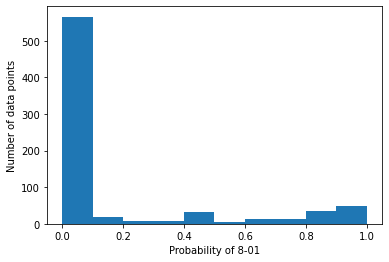

In [75]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of 8-01")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, Sport_8_01])

**<font size="5"><span style="color:red">Conclusion:</span></font>** <font size="4">
(1) Une possibilité: Dans les sessions de labelisation on réduit le choix aux catégories appartenant au TIER 1 seulement et on utilise SNORKEL pour précisier le TIER 3.
    
(2) Moins précis que (1), mais on peut utiliser SNORKEL sans info de TIER 1 d'avance.

</font>

In [81]:
from sklearn.preprocessing import MultiLabelBinarizer


Y = [gold_label_8]


# fit a MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit_transform(Y)

# create a label model and predict ALL probabilities 
predictions = label_model.predict_proba(L=L_train)
df_train['predict_proba'] = predictions.tolist()



# get all the non zero indices which are the multi labels
kneedle = KneeLocator(x, y, S=1.0, curve="concave", direction="increasing")


df_multilabel['multi_labels'] = df_multilabel['predict_proba'].apply(lambda x: np.nonzero(x)[0])

    
#transform to mlb for classification report
#df_multilabel['mlb_pred'] = df_multilabel['multi_labels'].apply(lambda x: mlb.transform([x])[0])
#print(df_multilabel.head())


#convert to str in order to see how many multi labels did we gain
#multi_label_string = df_multilabel.multi_labels.apply(lambda x: ", ".join(le.inverse_transform(x)))
#print(multi_label_string.value_counts()[:50])


# print some metrics using classification report 
#y_pred = df_multilabel.mlb_pred.apply(lambda x: list(x)).to_numpy().tolist()
#y_true = mlb.transform(Y.values).tolist()
#print(classification_report(y_true, y_pred, target_names = mlb.classes_))

,URL,content,category,label,predict_proba
1633,http://asebadminton.e-monsite.com/pages/le-bad...,Histoire du Badminton Qu'est-ce que le badmint...,8-03,3,"[0.016702715627280883, 0.001100425582390778, 1..."
1672,http://badminton-briviste.go1.cc/infos/tennis_...,Badminton vs Tennis Tennis vs Badminton\n\nQue...,8-03,3,"[4.852942828177488e-10, 0.0007249122089400147,..."
1673,http://badminton-de-casson.fr/le-club/le-materiel,Le matériel Raquettes-Volants Le badminton a l...,8-03,3,"[0.039947739623708185, 0.010570531117277113, 1..."
1674,http://badmintonconty.e-monsite.com/pages/orig...,origine du badminton L'origine du Badminton es...,8-03,3,"[0.016702715627280883, 0.001100425582390778, 1..."
1685,http://barbezieux.badminton.over-blog.com/page...,Le blog de barbezieux.badminton (Charente) His...,8-03,3,"[0.016702715627280883, 0.001100425582390778, 1..."
...,...,...,...,...,...
58059,https://www.wikizero.com/fr/Football_am%C3%A9r...,Football américain Football américain Fédérati...,8-01,1,"[4.854775948049034e-06, 0.9984310352054296, 7...."
58080,https://www.wilson.com/fr-fr/explore/volleybal...,Règles du beach-volley — Dimensions du terrain...,8-06,6,"[2.47505597461012e-08, 1.568197093316985e-05, ..."
58102,https://www.womensports.fr/le-beach-volley-pou...,"La question qui tue : le beach-volley, pourquo...",8-06,5,"[1.2511725557069388e-06, 0.0001997429485794808..."
58250,https://www.yonexifb.com/fr/l-evenement/presen...,Présentation Les Internationaux de France de B...,8-03,3,"[0.10681872813482036, 0.027897598600902327, 0...."
